In [1]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [2]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

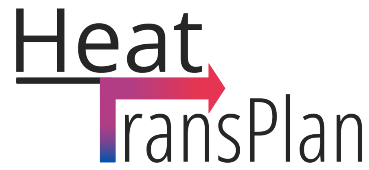


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

## Index
- [Check the format of the variables](#format-of-the-variables)
- [Visualize the all the variables together per hour](#Visualize-the-all-the-variables-together-per-hour)
- [Process Mining: tables, case ide and activities](#Process-Mining)
- [Process Mining: process discovery schritt_l01](#Process-discovery-visual)
- [Visualize all variables per minute](#Visualize-all-variables-per-minute)
- [Visualize all variables per hour](#Visualize-all-variables-per-hour)


In [3]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
import chardet#
import pandas as pd
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Format of the Variables

In [4]:
pd.set_option('display.max_rows', 10)

# Specify file path
file = "/Users/davidzapata/Documents/git/heattransplan/data/raw/hipp/UNIP Erwärmen 11 2024.csv"

# Detect file encoding
with open(file, "rb") as f:
    result = chardet.detect(f.read())
    print("Detected encoding:", result)

# Read the CSV file
df_raw = pd.read_csv(file, sep=';', decimal=",", encoding=result['encoding'])

print()
# Print initial information about the DataFrame
print("Initial DataFrame info:")
print(df_raw.info())
print()
print("Columns before dropping:", df_raw.columns.tolist())

# Identify columns to drop
columns_to_drop = [col for i, col in enumerate(df_raw.columns) 
                   if "time" in col.lower() and i != 0]  # Keep the first column containing "time"

# Drop identified columns
df_raw = df_raw.drop(columns=columns_to_drop)

print()
# Print updated information about the DataFrame
print("Columns after dropping:", df_raw.columns.tolist())
print("Updated DataFrame info:")


df_raw = df_raw.rename(columns={"Schritt L01 Time": "datetime"})
# Rename columns with multiple transformations
df_raw = df_raw.rename(columns=lambda x: x.replace("ValueY", "")
                                      .replace(".", "")
                                      .replace(" ", "_")
                                      .lower())

df_raw = df_raw.dropna(subset=['datetime'])
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], format='%d.%m.%Y %H:%M:%S')
print()
print(df_raw.info())
# Rename the specific column to "datetime"

# Display the DataFrame
df_raw

Detected encoding: {'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}

Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368729 entries, 0 to 368728
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Schritt L01 Time        368728 non-null  object 
 1   Schritt L01 ValueY      368728 non-null  float64
 2   Menge L01 Time          368728 non-null  object 
 3   Menge L01 ValueY        368728 non-null  float64
 4   Menge L02 Time          368728 non-null  object 
 5   Menge L02 ValueY        368728 non-null  float64
 6   Schritt L02 Time        368728 non-null  object 
 7   Schritt L02 ValueY      368728 non-null  float64
 8   Temp L01 Time           368728 non-null  object 
 9   Temp L01 ValueY         368728 non-null  float64
 10  Temp L02 Time           368728 non-null  object 
 11  Temp L02 ValueY         368728 non-null  float64
 12  Mat. ID M01 Time        36

datetime  schritt_l01_  menge_l01_  menge_l02_  \
0      2024-11-03 14:03:21           0.0         0.0         0.0   
1      2024-11-03 14:03:26           0.0         0.0         0.0   
2      2024-11-03 14:03:31           0.0         0.0         0.0   
3      2024-11-03 14:03:36           0.0         0.0         0.0   
4      2024-11-03 14:03:41           0.0         0.0         0.0   
...                    ...           ...         ...         ...   
368723 2024-11-24 22:10:16           0.0         0.0         0.0   
368724 2024-11-24 22:10:21           0.0         0.0         0.0   
368725 2024-11-24 22:10:26           0.0         0.0         0.0   
368726 2024-11-24 22:10:31           0.0         0.0         0.0   
368727 2024-11-24 22:10:36           0.0         0.0         0.0   

        schritt_l02_  temp_l01_  temp_l02_  mat_id_m01_  mat_id_m02_  \
0                0.0  31.201172  29.909939            0            0   
1                0.0  31.201172  29.915365            0            0   
2                0.0  31.201172  29.909939            0            0   
3                0.0  31.201172  29.909939            0            0   
4                0.0  31.195747  29.909939            0            0   
...              ...        ...        ...          ...          ...   
368723           0.0  63.677299  26.844618            0            0   
368724           0.0  63.709854  26.844618            0            0   
368725           0.0  63.736980  26.844618            0            0   
368726           0.0  63.764107  26.833767            0            0   
368727           0.0  63.785809  26.844618            0            0   

        mat_id_m03_  massenstrom_l01_  massenstrom_l02_    hw_l01_    hw_l02_  
0                 0          0.000000               0.0  33.582901  30.777994  
1                 0          0.000000               0.0  33.582901  30.777994  
2                 0          0.000000               0.0  33.582901  30.777994  
3                 0          0.000000               0.0  33.582901  30.772570  
4                 0          0.000000               0.0  33.582901  30.783421  
...             ...               ...               ...        ...        ...  
368723            0      15295.637695               0.0  69.238281  28.059896  
368724            0      15455.648438               0.0  69.194878  28.054470  
368725            0      15608.243164               0.0  69.135201  28.059896  
368726            0      15756.002930               0.0  69.102646  28.054470  
368727            0      15947.857422               0.0  69.048393  28.059896  

[368728 rows x 14 columns]

Variables acording to excel file:
    - Hw: Temperature Damp in (Temp in always 4-6 and not measured)
    - Schritt (Machine status, Line 01?)
    - Mat_id (ID of the Recipe. Where exaclty is not clear)

It says in excel that the Mass flow of damp is not given, only of the product. But in the data are 2 groups of variables (Massenstrom and Menge). Not clear what is what. Menge and Massentrrom correlate strongly, when one is activate the other is also activated.

In [5]:
df = df_raw

describe = df['menge_l01_'].describe()
describe

count    368728.000000
mean         55.101902
std         276.772872
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3091.948730
Name: menge_l01_, dtype: float64

In [6]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def visualize_data(df, datetime_col, library="plotly"):
    """
    Visualize each variable in a DataFrame with descriptive stats, histogram, and linechart.
    
    Parameters:
    - df: pandas DataFrame
    - datetime_col: column name for datetime values
    - library: visualization library to use ('plotly' or 'seaborn')
    """
    # Ensure the datetime column is in datetime format

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", context="talk")

    for col in df.columns:
        if col == datetime_col:
            continue  # Skip the datetime column

        print(f"Variable: {col}")
        print(df[col].describe())
        print(f"Unique values: {df[col].nunique()}")
        print("-" * 60)

        if library == "plotly":
            # Plotly Histograms
            fig_hist = px.histogram(df, x=col, title=f"Histogram of {col}")
            fig_hist.show()

            # Plotly Line Chart
            fig_line = px.line(df, x=datetime_col, y=col, title=f"{col}")
            fig_line.show()

        elif library == "seaborn":
            # Seaborn Histogram
            plt.figure(figsize=(20, 6))
            sns.histplot(df[col], kde=True, bins=30, color="green", edgecolor="black")
            plt.title(f"Histogram of {col}", fontsize=16)
            plt.xlabel(col, fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.show()

            # Seaborn Line Chart
            plt.figure(figsize=(20, 6))
            sns.lineplot(data=df, x=datetime_col, y=col, color="green", linewidth=2.5)
            plt.title(f"{col} Over Time", fontsize=16)
            plt.xlabel("Datetime", fontsize=14)
            plt.ylabel(col, fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()

        print("=" * 200) 



- [Index](#Index)

In [7]:
 #### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Define columns to aggregate with mean
mean_columns = ['datetime', 'schritt_l01_', 'menge_l01_', 'menge_l02_', 'schritt_l02_', 
                'temp_l01_', 'temp_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_', 
                'massenstrom_l01_', 'massenstrom_l02_', 'hw_l01_', 'hw_l02_']

# Define columns to aggregate with first
first_columns = ['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})

# Resample by minute and apply custom aggregation
df_resampled_5_min = df_raw.resample('5T', on='datetime').agg(agg_dict).reset_index(drop=True)

In [8]:
 #### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Define columns to aggregate with mean
mean_columns = ['datetime', 'schritt_l01_', 'menge_l01_', 'menge_l02_', 'schritt_l02_', 
                'temp_l01_', 'temp_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_', 
                'massenstrom_l01_', 'massenstrom_l02_', 'hw_l01_', 'hw_l02_']

# Define columns to aggregate with first
first_columns = ['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})

# Resample by minute and apply custom aggregation
df_resampled_1H = df_raw.resample('H', on='datetime').agg(agg_dict).reset_index(drop=True)

#### Agregate the dataset from values every 2 sec to values per 5 Min and per hour

# Correlation Matrix

In [9]:
import pandas as pd
import plotly.express as px

# Assuming df_resampled is already defined and contains your data
df = df_resampled_5_min.copy()

# Step 1: Calculate the correlation matrix
corr_matrix = df.corr()

# Step 2: Plot the heatmap using Plotly
fig = px.imshow(corr_matrix, 
                text_auto=".1f",  # Round the correlation coefficients to one decimal place
                color_continuous_scale='RdBu',  # Red to blue color scale
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                title="Correlation Matrix Heatmap",
                width=800,  # Increase the width
                height=800)  # Increase the height


print(' Correlation in 5 Min spans')
# Step 3: Show the plot
fig.show()



 Correlation in 5 Min spans


- [Index](#Index)

# Visualize the all the variables together per hour

Click on the legend to select individual variables

In [10]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H.copy()

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Create the Plotly figure
fig = px.line(df, x='datetime', y=df.columns.drop('datetime'),
              labels={col: col for col in df.columns if col != 'datetime'},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

- [Index](#Index)

 # Visualize the all the variables together scaling them from 0 to 1

 #### It is posible to select individual variables on the legend

In [11]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df_resampled' is your original DataFrame
df = df_resampled_1H.copy()


# Exclude the 'datetime' column for scaling
columns_to_scale = df.columns.drop('datetime')

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Create the Plotly figure
fig = px.line(df, x='datetime', y=columns_to_scale,
              labels={col: col for col in columns_to_scale},
              title='Interactive Visualization of Scaled Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

## Show unique values per column

In [12]:
df = df_raw.copy()
df = df.dropna(subset=["schritt_l01_"])


print('schritt_l01_ :', df['schritt_l01_'].unique())
print('schritt_l02_ :',df['schritt_l02_'].unique())
print('mat_id_m01_ :' ,df['mat_id_m01_'].unique())
print('mat_id_m02_ :',df['mat_id_m02_'].unique())
print('mat_id_m03_ :',df['mat_id_m03_'].unique())

schritt_l01_ : [  0.   3.   4. 100.   7.  15.  30.  40.  33.  42. 105.   5.]
schritt_l02_ : [  0.   3.   4. 100.   7.  15.  30.  33.  40.  42. 105.   5.]
mat_id_m01_ : [      0 8681981 8681982 8681983 8681588 8681697 8681590 8681592 8681607
 8842020 8842021 8842022]
mat_id_m02_ : [      0 8681588 8681697 8681590 8681592 8681607]
mat_id_m03_ : [      0 8681588 8681697 8681590 8681607]


# Process Mining

Show rows of the dataframe per hour to see combinations of Schritt and mat 

In [13]:
create_hide_button()

pd.set_option('display.max_rows', None)     # Show all rows

df = df_resampled_1H[['datetime','schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]#.drop_duplicates()

df['unique_columns'] = df[['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

df = df#.drop_duplicates(subset=['unique_columns'], keep='first')

df

datetime  schritt_l01_  schritt_l02_  mat_id_m01_  \
0   2024-11-03 14:31:38.500           0.0           0.0            0   
1   2024-11-03 15:29:58.500           0.0           0.0            0   
2   2024-11-03 16:29:58.500           0.0           0.0            0   
3   2024-11-03 17:29:58.500           0.0           0.0            0   
4   2024-11-03 18:29:58.500           0.0           0.0            0   
5   2024-11-03 19:29:58.500           0.0           0.0            0   
6   2024-11-03 20:29:58.500           0.0           0.0            0   
7   2024-11-03 21:29:58.500           0.0           0.0            0   
8   2024-11-03 22:29:58.500           0.0           0.0            0   
9   2024-11-03 23:29:58.500           0.0           0.0            0   
10  2024-11-04 00:29:58.500           0.0           0.0            0   
11  2024-11-04 01:29:58.500           0.0           0.0            0   
12  2024-11-04 02:29:58.500           0.0           0.0            0   
13  2024-11-04 03:29:58.500           0.0           0.0            0   
14  2024-11-04 04:29:58.500           0.0           0.0            0   
15  2024-11-04 05:29:58.500           0.0           0.0            0   
16  2024-11-04 06:29:58.500           0.0           0.0            0   
17  2024-11-04 07:29:58.500           0.0           0.0            0   
18  2024-11-04 08:29:58.500           0.0           0.0      8681981   
19  2024-11-04 09:29:58.500           4.0           0.0      8681981   
20  2024-11-04 10:29:58.500           4.0           0.0      8681981   
21  2024-11-04 11:29:58.500           0.0           0.0      8681982   
22  2024-11-04 12:29:58.500           4.0           4.0      8681982   
23  2024-11-04 13:29:58.500           4.0           4.0      8681982   
24  2024-11-04 14:29:58.500           4.0           4.0      8681982   
25  2024-11-04 15:29:58.500           4.0           4.0      8681983   
26  2024-11-04 16:29:58.500           4.0           4.0      8681983   
27  2024-11-04 17:29:58.500           4.0           4.0            0   
28  2024-11-04 18:29:58.500           4.0           4.0            0   
29  2024-11-04 19:29:58.500           4.0           4.0            0   
30  2024-11-04 20:29:58.500          30.0           0.0            0   
31  2024-11-04 21:29:58.500           4.0           4.0            0   
32  2024-11-04 22:29:58.500           4.0           4.0            0   
33  2024-11-04 23:29:58.500           4.0           4.0            0   
34  2024-11-05 00:29:58.500           4.0          30.0            0   
35  2024-11-05 01:29:58.500           4.0          30.0            0   
36  2024-11-05 02:29:58.500           4.0           4.0            0   
37  2024-11-05 03:29:58.500           4.0           4.0            0   
38  2024-11-05 04:29:58.500           4.0           4.0            0   
39  2024-11-05 05:29:58.500           4.0           4.0            0   
40  2024-11-05 06:29:58.500           4.0           4.0            0   
41  2024-11-05 07:29:58.500           0.0           4.0      8681588   
42  2024-11-05 08:29:58.500           4.0           4.0      8681588   
43  2024-11-05 09:29:58.500           4.0           4.0      8681588   
44  2024-11-05 10:29:58.500           4.0           4.0      8681588   
45  2024-11-05 11:29:58.500           4.0           4.0      8681588   
46  2024-11-05 12:29:58.500           4.0           4.0      8681588   
47  2024-11-05 13:29:58.500           4.0           4.0      8681588   
48  2024-11-05 14:29:58.500           4.0           4.0      8681588   
49  2024-11-05 15:29:58.500           4.0           4.0      8681588   
50  2024-11-05 16:29:58.500          30.0           4.0      8681588   
51  2024-11-05 17:29:58.500           4.0          30.0            0   
52  2024-11-05 18:29:58.500           4.0           4.0            0   
53  2024-11-05 19:29:58.500           4.0           4.0            0   
54  2024-11-05 20:29:58.500           4.0           4.0    

- Create a case id for Schritt_l01. Case_ide = mat_id_m01 + first appereance of that material in the process
- Combine case ide with process steps (machine status) to filter and have only the first time that happenen

It is not clear how the processes are connected together. Is Mat01 going to Schritt L01?

In [14]:
create_hide_button()

pd.set_option('display.max_rows', None)  

df = df_resampled_1H[['datetime', 'schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]

column = 'schritt_l01_'

#df = df[df[column]>0]

df[column] = column + df[column].astype(str)

# Detect changes in 'mat_id_m01_' and mark them with 1
df['change'] = (df['mat_id_m01_'] != df['mat_id_m01_'].shift()).astype(int)

# Create a cumulative sum of the changes
df['change_cumsum'] = df['change'].cumsum()

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id'] = df['mat_id_m01_'].astype(str) + '_' + df['change_cumsum'].astype(str)

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id_activity'] = df['case_id'] + '_' + df['schritt_l01_']

df = df.drop_duplicates(subset=['case_id_activity'])

#df = df[df['mat_id_m01_']>0]

store_df = df.copy()
store_df 

datetime       schritt_l01_  schritt_l02_  mat_id_m01_  \
0   2024-11-03 14:31:38.500    schritt_l01_0.0           0.0            0   
18  2024-11-04 08:29:58.500    schritt_l01_0.0           0.0      8681981   
19  2024-11-04 09:29:58.500    schritt_l01_4.0           0.0      8681981   
21  2024-11-04 11:29:58.500    schritt_l01_0.0           0.0      8681982   
22  2024-11-04 12:29:58.500    schritt_l01_4.0           4.0      8681982   
25  2024-11-04 15:29:58.500    schritt_l01_4.0           4.0      8681983   
27  2024-11-04 17:29:58.500    schritt_l01_4.0           4.0            0   
30  2024-11-04 20:29:58.500   schritt_l01_30.0           0.0            0   
41  2024-11-05 07:29:58.500    schritt_l01_0.0           4.0      8681588   
42  2024-11-05 08:29:58.500    schritt_l01_4.0           4.0      8681588   
50  2024-11-05 16:29:58.500   schritt_l01_30.0           4.0      8681588   
51  2024-11-05 17:29:58.500    schritt_l01_4.0          30.0            0   
55  2024-11-05 21:29:58.500    schritt_l01_4.0           4.0      8681588   
63  2024-11-06 05:29:58.500    schritt_l01_0.0           0.0      8681588   
68  2024-11-06 10:29:58.500    schritt_l01_4.0           4.0            0   
74  2024-11-06 16:29:58.500    schritt_l01_0.0           0.0            0   
76  2024-11-06 18:29:58.500    schritt_l01_4.0           4.0      8681588   
87  2024-11-07 05:29:58.500    schritt_l01_0.0           4.0            0   
88  2024-11-07 06:29:58.500    schritt_l01_4.0           4.0            0   
92  2024-11-07 10:29:58.500    schritt_l01_4.0           4.0      8681588   
94  2024-11-07 12:29:58.500   schritt_l01_30.0           4.0      8681588   
97  2024-11-07 15:29:58.500    schritt_l01_0.0           4.0      8681588   
104 2024-11-07 22:29:58.500    schritt_l01_4.0           4.0            0   
107 2024-11-08 01:29:58.500   schritt_l01_30.0           4.0            0   
109 2024-11-08 03:29:58.500    schritt_l01_0.0           0.0            0   
113 2024-11-08 07:29:58.500    schritt_l01_4.0           4.0      8681697   
116 2024-11-08 10:29:58.500   schritt_l01_30.0           4.0      8681697   
117 2024-11-08 11:29:58.500  schritt_l01_100.0           4.0      8681697   
121 2024-11-08 15:29:58.500    schritt_l01_0.0           4.0      8681697   
129 2024-11-08 23:29:58.500    schritt_l01_4.0           4.0            0   
130 2024-11-09 00:29:58.500    schritt_l01_4.0           4.0      8681697   
132 2024-11-09 02:29:58.500    schritt_l01_0.0           0.0      8681697   
135 2024-11-09 05:29:58.500   schritt_l01_30.0           4.0      8681697   
141 2024-11-09 11:29:58.500    schritt_l01_0.0           0.0            0   
182 2024-11-11 04:29:58.500    schritt_l01_4.0           4.0            0   
184 2024-11-11 06:29:58.500    schritt_l01_4.0           4.0      8681590   
186 2024-11-11 08:29:58.500   schritt_l01_30.0           4.0      8681590   
187 2024-11-11 09:29:58.500  schritt_l01_100.0           4.0      8681590   
195 2024-11-11 17:29:58.500    schritt_l01_0.0           0.0      8681590   
197 2024-11-11 19:29:58.500    schritt_l01_4.0           4.0            0   
198 2024-11-11 20:29:58.500    schritt_l01_4.0           4.0      8681590   
199 2024-11-11 21:29:58.500   schritt_l01_30.0           4.0      8681590   
204 2024-11-12 02:29:58.500    schritt_l01_0.0           4.0      8681590   
207 2024-11-12 05:29:58.500    schritt_l01_0.0           0.0            0   
216 2024-11-12 14:29:58.500   schritt_l01_30.0           4.0      8681590   
217 2024-11-12 15:29:58.500    schritt_l01_4.0          30.0      8681590   
230 2024-11-13 04:29:58.500   schritt_l01_30.0           4.0            0   
231 2024-11-13 05:29:58.500    schritt_l01_4.0           4.0            0   
235 2024-11-13 09:29:58.500    schritt_l01_4.0           4.0      8681590   
237 2024-11-13 11:29:58.500   schritt_l01_30.0           4.0      8681590   
248 2024-11-13 22:29:58.500    schritt_l01_4.0           4.0            0   
249 2024-11-13 

# Process discovery visual
##### Show a process graph for schritt_l01

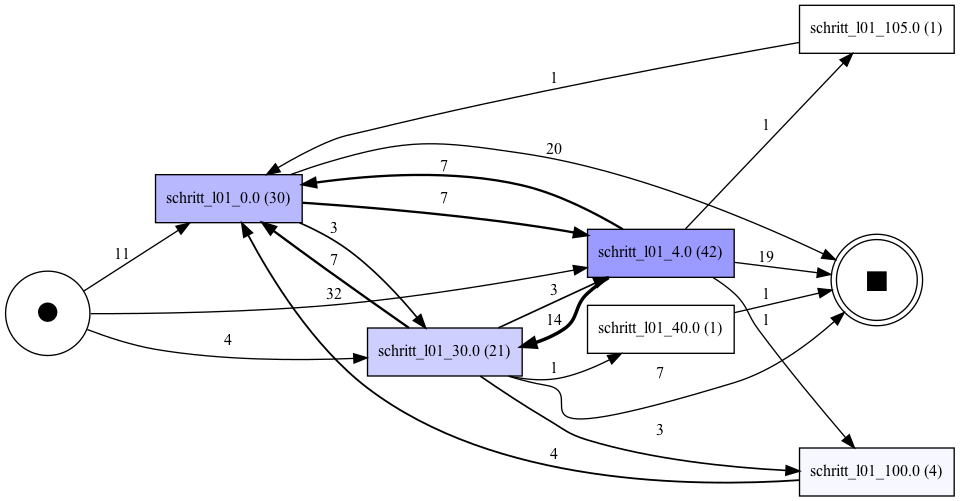

In [15]:
import pm4py
import pandas as pd

#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
process_df = store_df#[store_df['process_name'] == process]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(process_df, case_id='case_id', activity_key='schritt_l01_', timestamp_key='datetime')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

- [Index](#Index)

 # Visualize all variables per minute

datetime  schritt_l01_  menge_l01_  menge_l02_  \
0    2024-11-03 14:04:08.500           0.0         0.0         0.0   
1    2024-11-03 14:07:28.500           0.0         0.0         0.0   
2    2024-11-03 14:12:28.500           0.0         0.0         0.0   
3    2024-11-03 14:17:28.500           0.0         0.0         0.0   
4    2024-11-03 14:22:28.500           0.0         0.0         0.0   
...                      ...           ...         ...         ...   
6142 2024-11-24 21:52:28.500           0.0         0.0         0.0   
6143 2024-11-24 21:57:28.500           0.0         0.0         0.0   
6144 2024-11-24 22:02:28.500           0.0         0.0         0.0   
6145 2024-11-24 22:07:28.500           0.0         0.0         0.0   
6146 2024-11-24 22:10:18.500           0.0         0.0         0.0   

      schritt_l02_  temp_l01_  temp_l02_  mat_id_m01_  mat_id_m02_  \
0              0.0  31.194933  29.912381            0            0   
1              0.0  31.218262  29.930917            0            0   
2              0.0  31.239601  29.966092            0            0   
3              0.0  31.260218  29.996835            0            0   
4              0.0  31.259585  30.039424            0            0   
...            ...        ...        ...          ...          ...   
6142           0.0  77.384078  26.853751            0            0   
6143           0.0  78.219853  26.851310            0            0   
6144           0.0  52.311017  26.848778            0            0   
6145           0.0  34.732892  26.845884            0            0   
6146           0.0  63.692221  26.844618            0            0   

      mat_id_m03_  massenstrom_l01_  massenstrom_l02_    hw_l01_    hw_l02_  
0               0          0.000000               0.0  33.583172  30.779080  
1               0          0.000000               0.0  33.585251  30.790202  
2               0          0.000000               0.0  33.601436  30.824562  
3               0          0.000000               0.0  33.637243  30.852141  
4               0          0.000000               0.0  33.677662  30.885055  
...           ...               ...               ...        ...        ...  
6142            0      12914.145435               0.0  72.732928  28.071108  
6143            0      16213.515535               0.0  74.471029  28.068576  
6144            0      16644.530941               0.0  72.373679  28.064507  
6145            0      14537.906331               0.0  70.740469  28.063784  
6146            0      15356.956543               0.0  69.206407  28.058540  

[6147 rows x 14 columns]

Variable: schritt_l01_
count    6147.000000
mean        4.650236
std        10.950901
min         0.000000
25%         0.000000
50%         4.000000
75%         4.000000
max       105.000000
Name: schritt_l01_, dtype: float64
Unique values: 12
------------------------------------------------------------


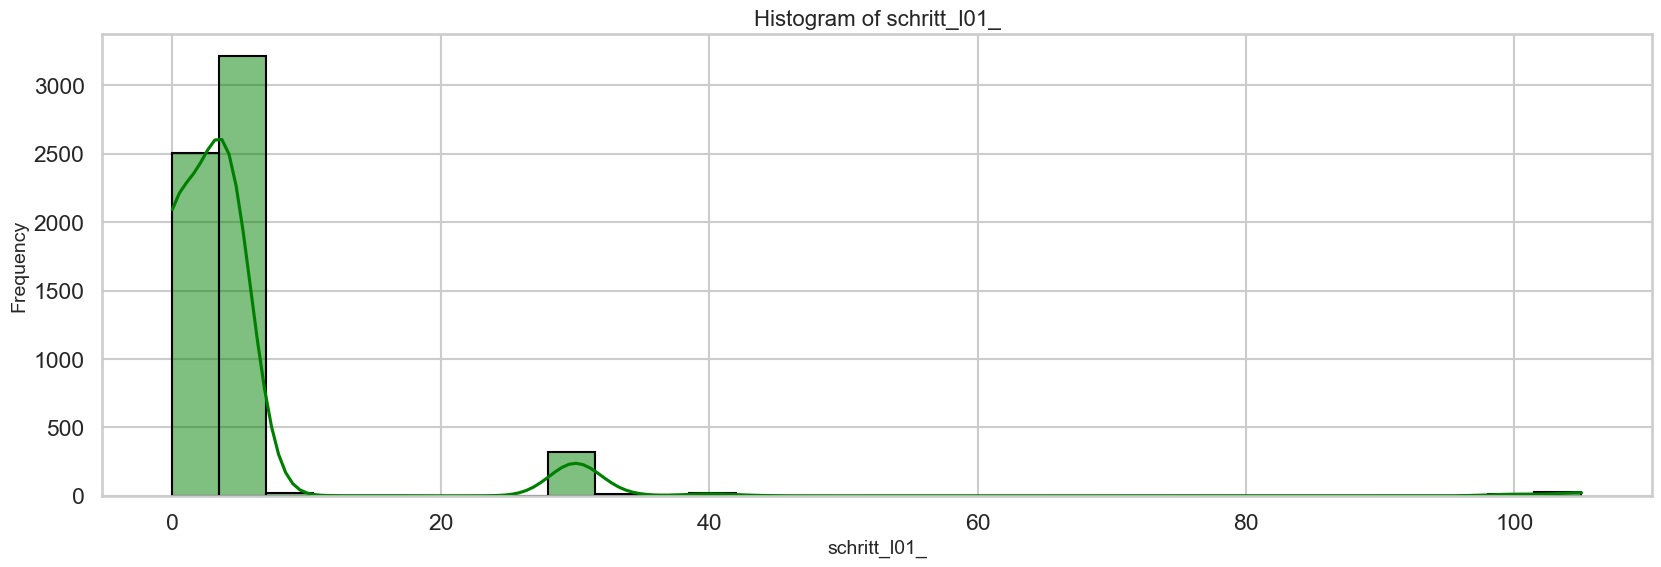

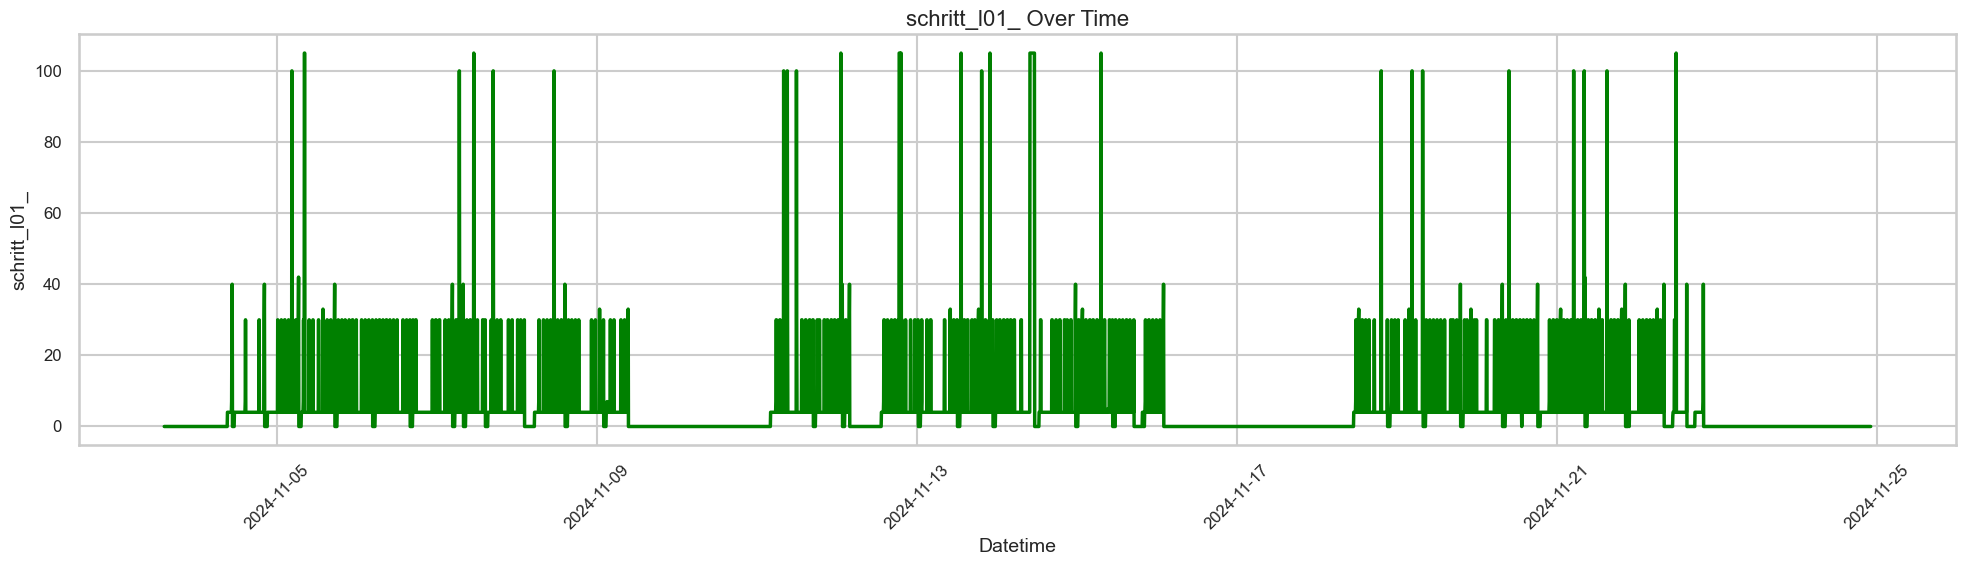

Variable: menge_l01_
count    6147.000000
mean       55.088157
std       224.702269
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1975.826782
Name: menge_l01_, dtype: float64
Unique values: 610
------------------------------------------------------------


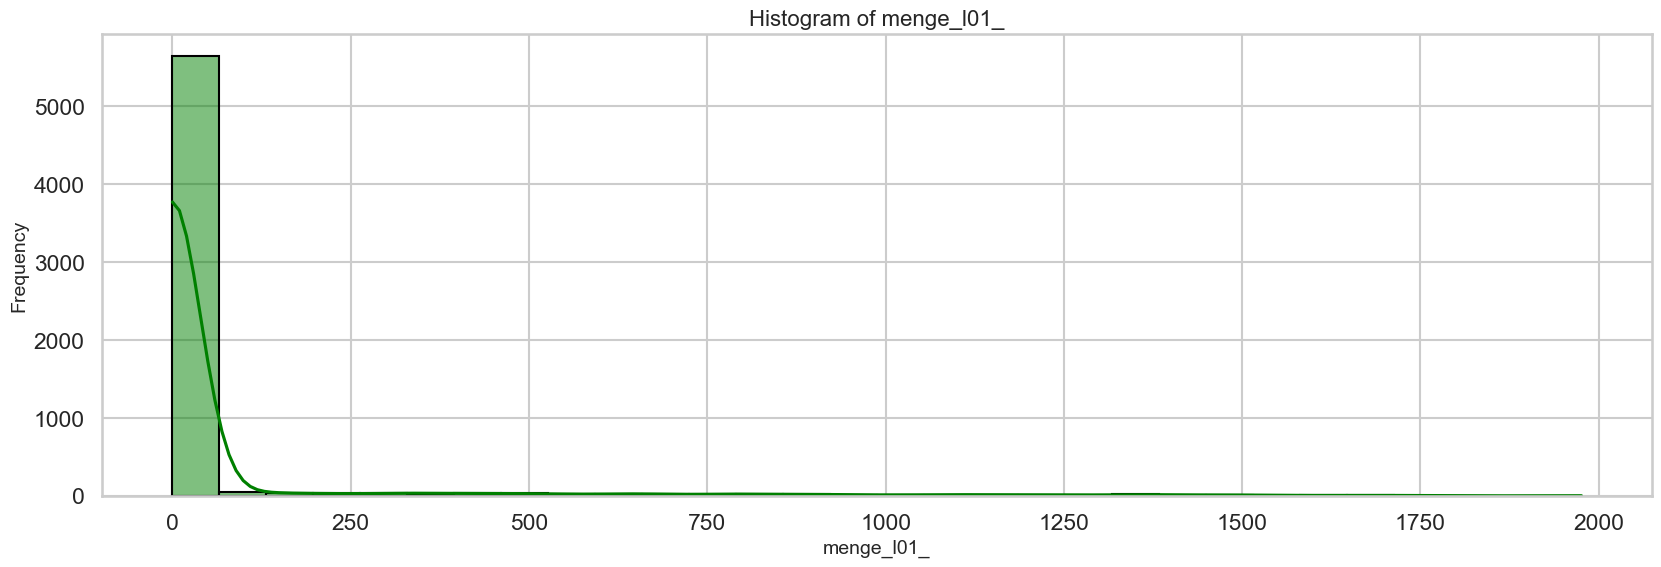

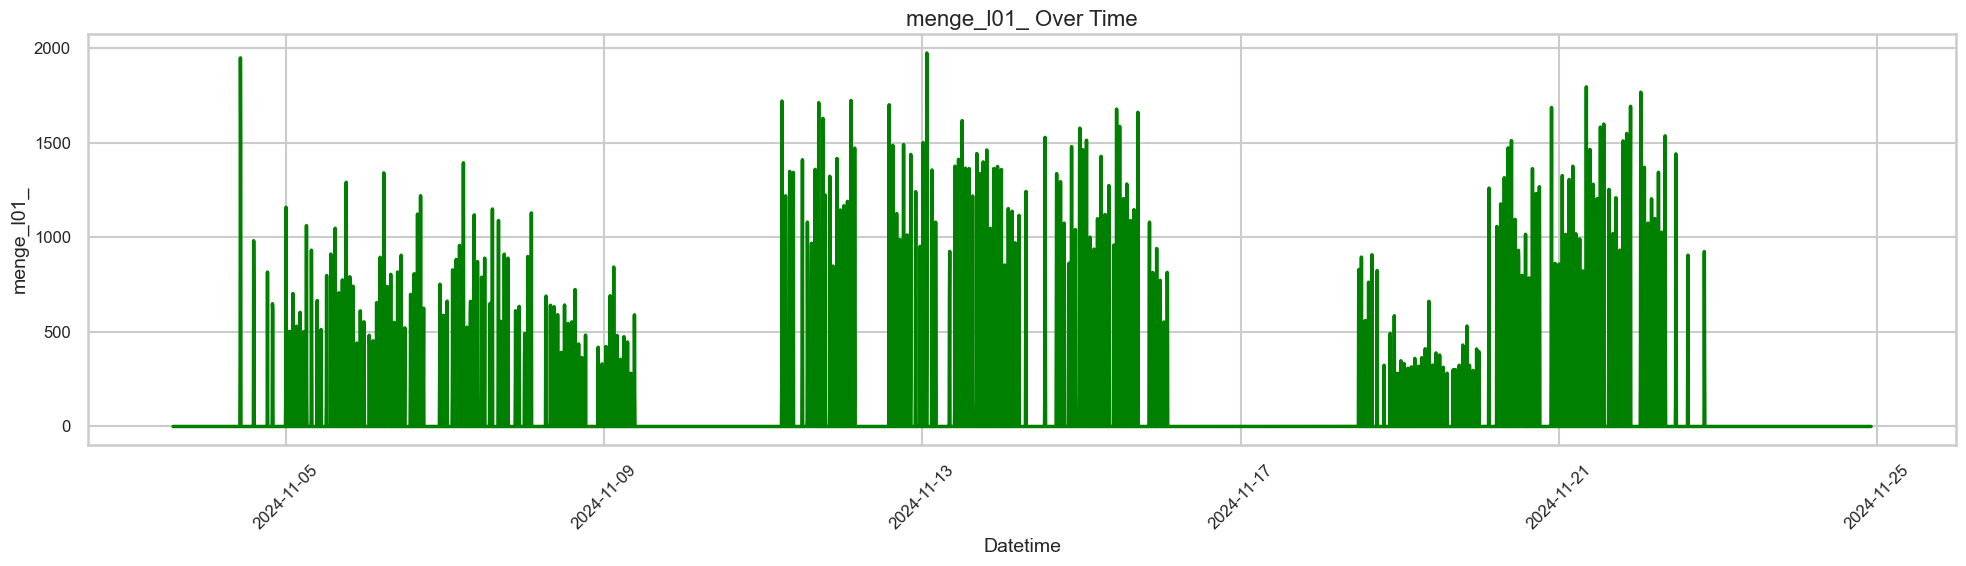

Variable: menge_l02_
count    6147.000000
mean       30.293717
std       154.604249
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2563.834204
Name: menge_l02_, dtype: float64
Unique values: 549
------------------------------------------------------------


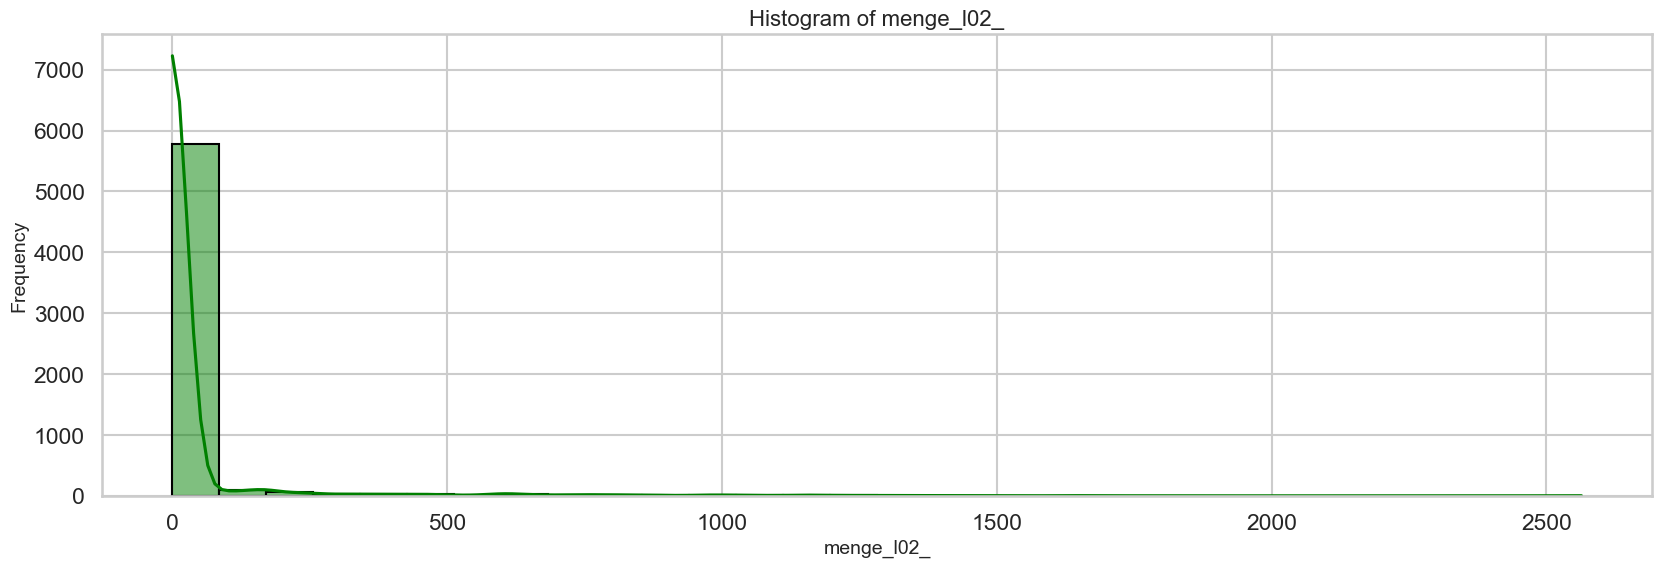

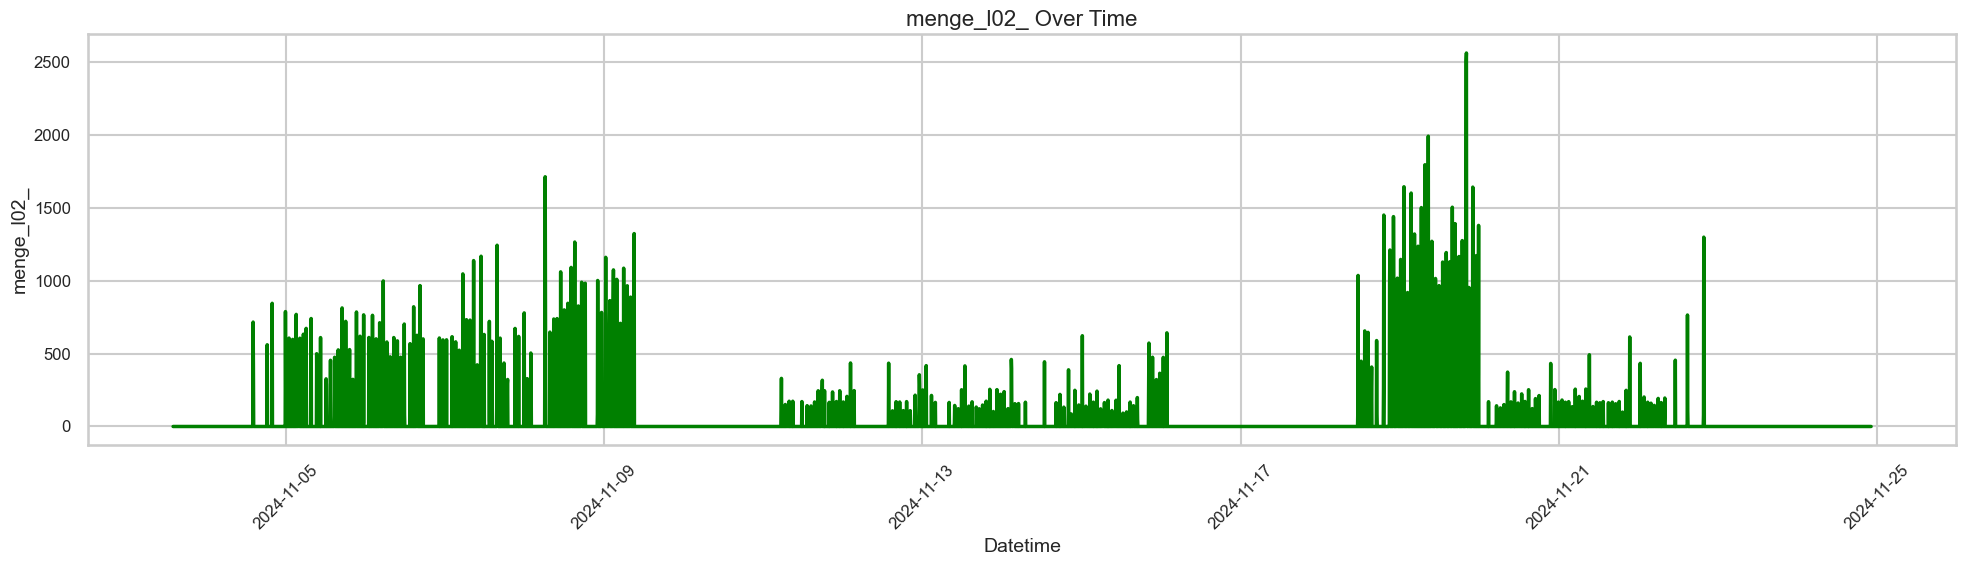

Variable: schritt_l02_
count    6147.000000
mean        4.076135
std         8.553923
min         0.000000
25%         0.000000
50%         4.000000
75%         4.000000
max       105.000000
Name: schritt_l02_, dtype: float64
Unique values: 11
------------------------------------------------------------


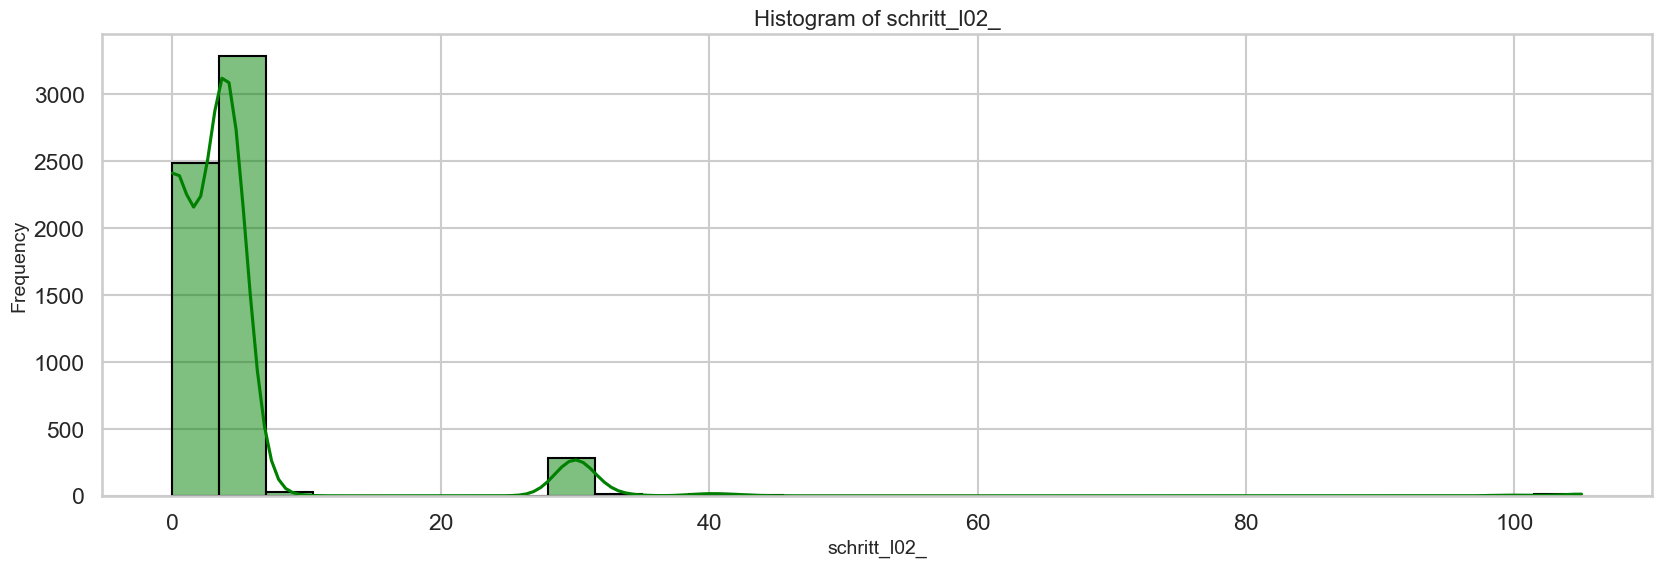

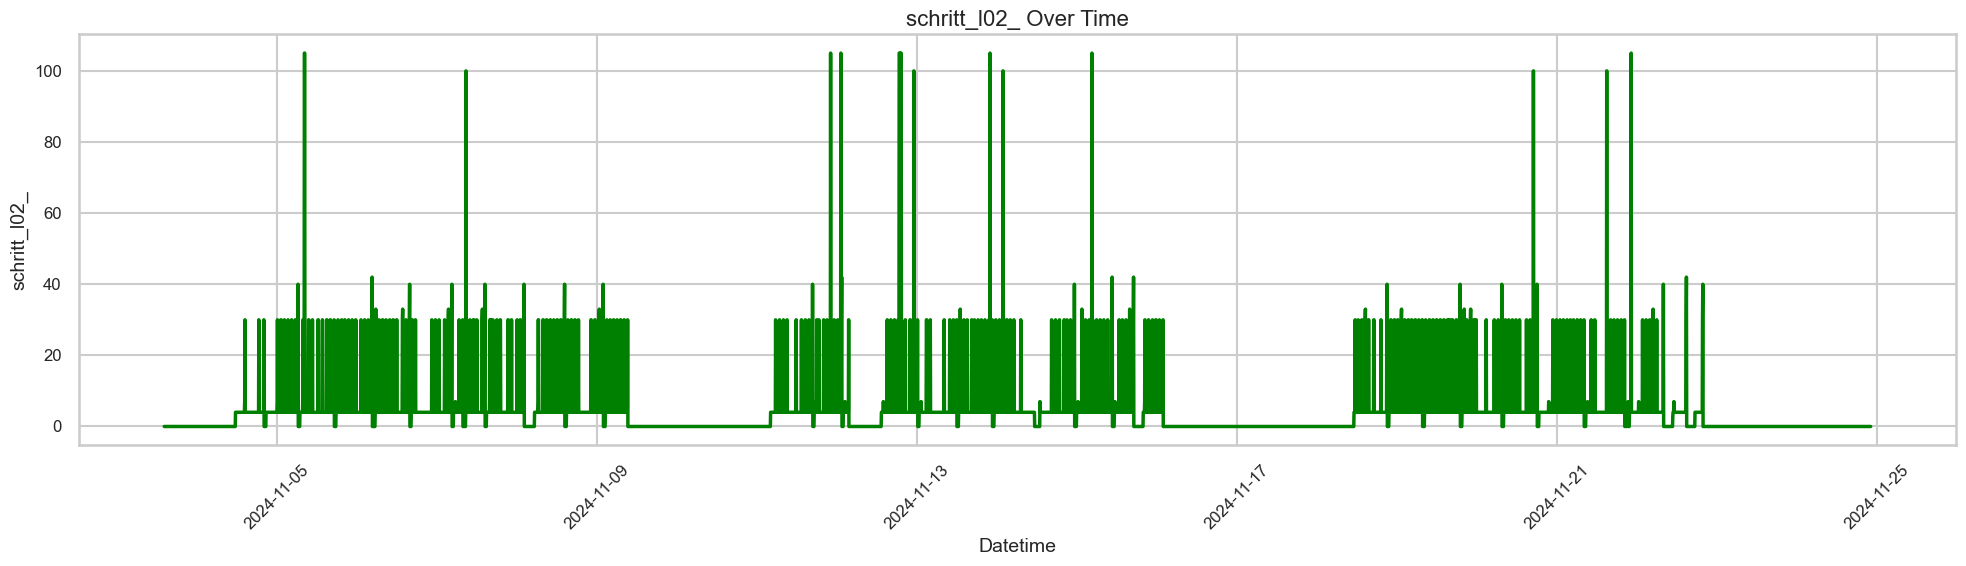

Variable: temp_l01_
count    6147.000000
mean       45.039541
std        14.688143
min        14.743381
25%        29.747631
50%        46.744249
75%        58.158185
max        78.824689
Name: temp_l01_, dtype: float64
Unique values: 6142
------------------------------------------------------------


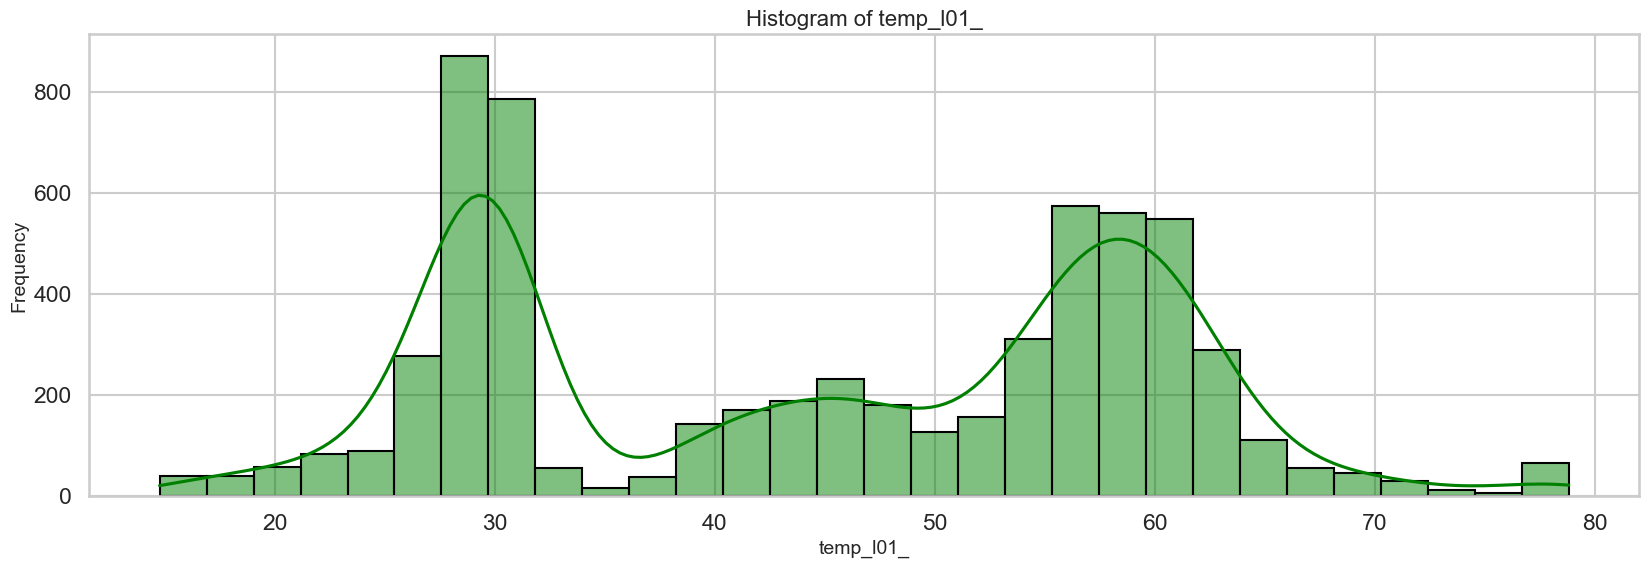

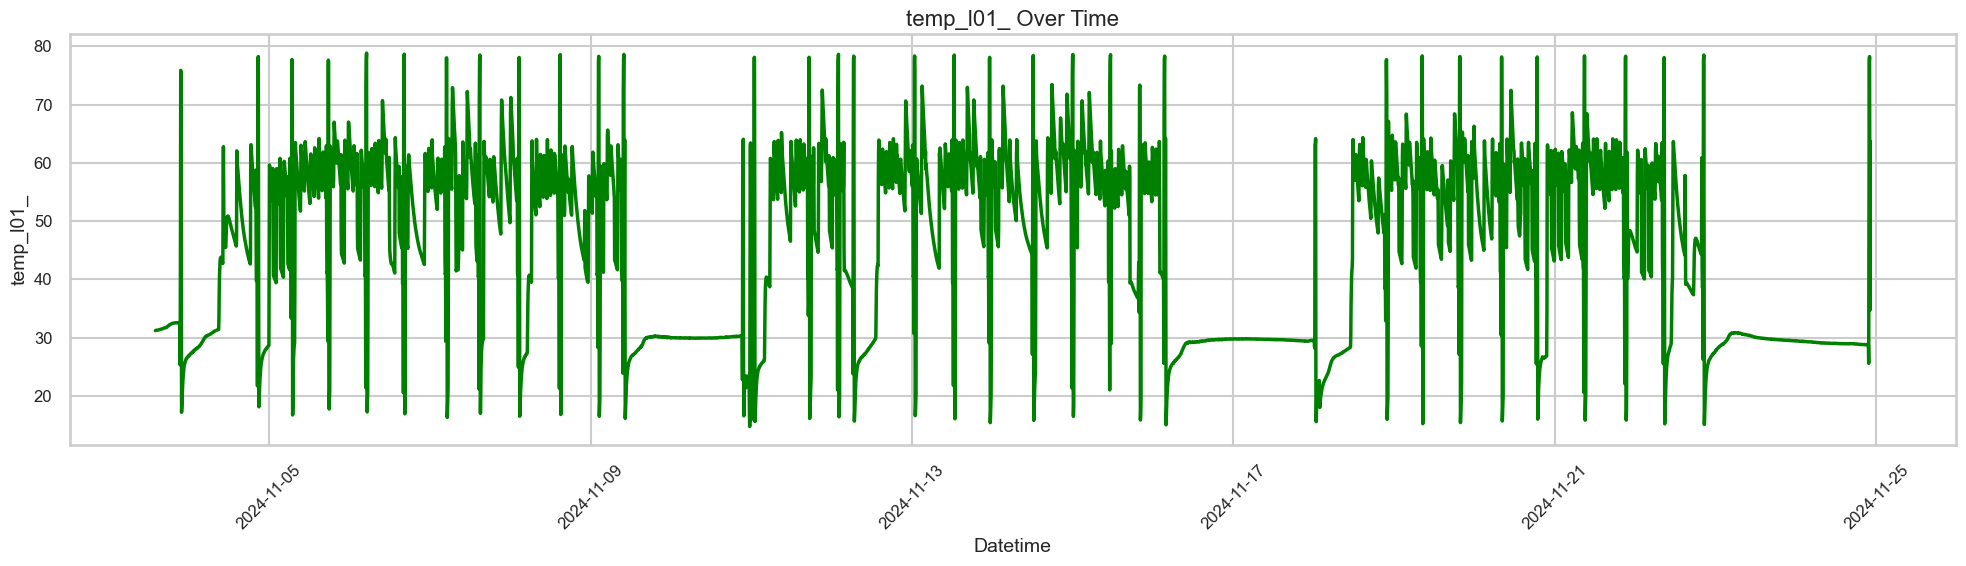

Variable: temp_l02_
count    6147.000000
mean       51.040224
std        20.607049
min        14.953794
25%        28.788565
50%        56.586553
75%        69.896556
max        93.971264
Name: temp_l02_, dtype: float64
Unique values: 6145
------------------------------------------------------------


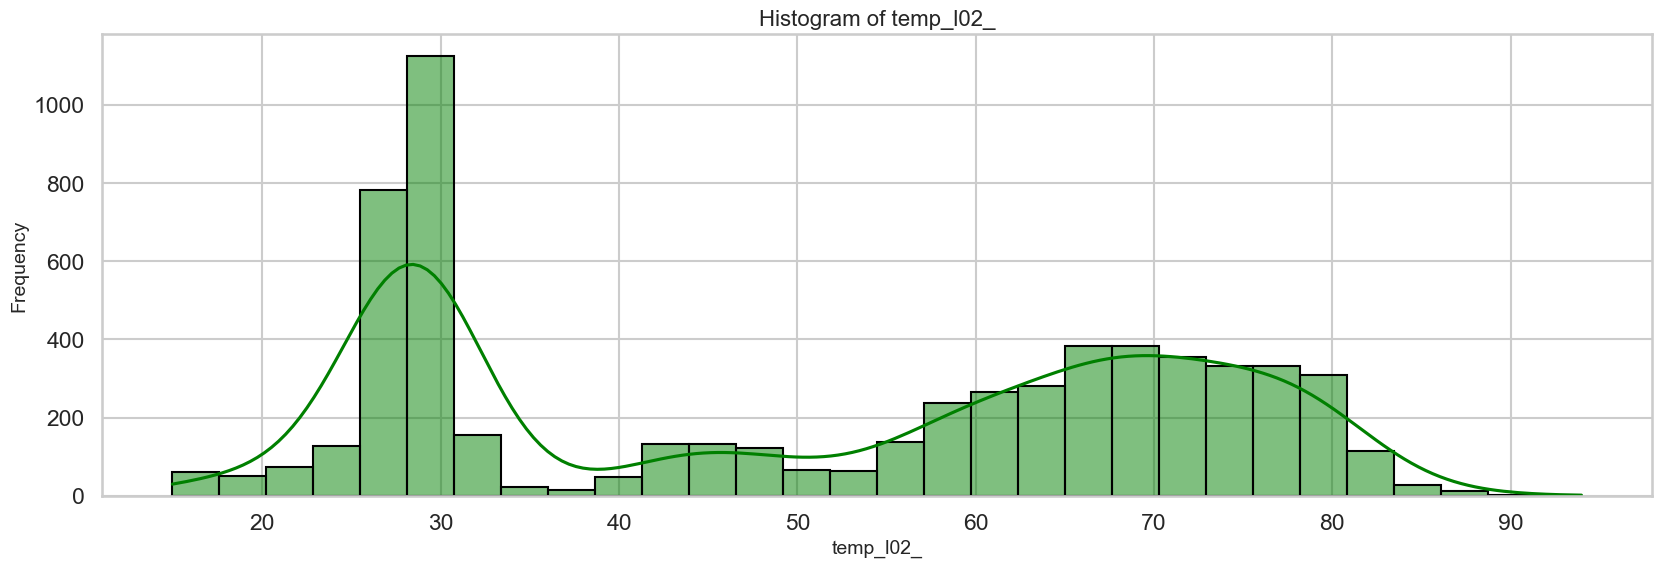

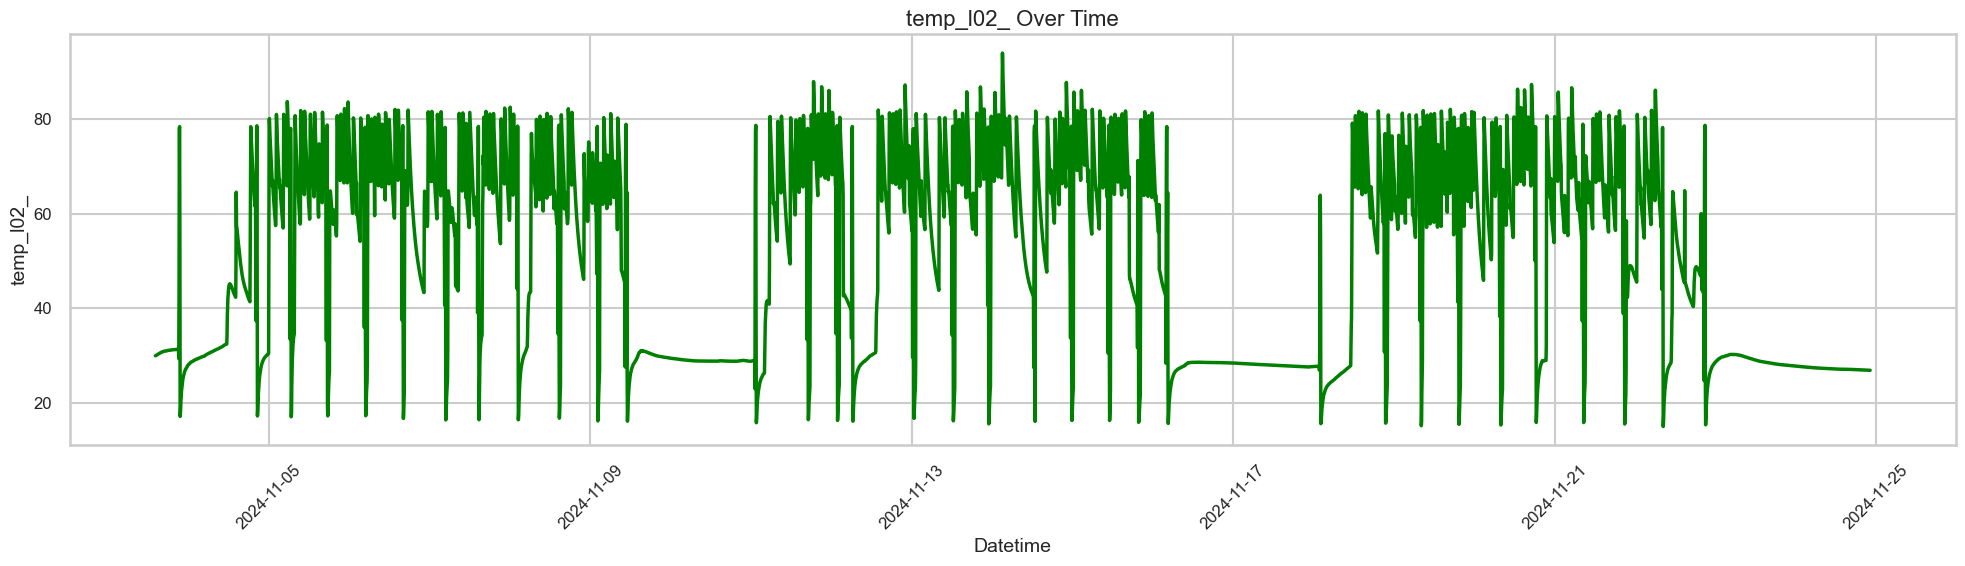

Variable: mat_id_m01_
count    6.147000e+03
mean     4.133055e+06
std      4.341081e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681590e+06
max      8.842022e+06
Name: mat_id_m01_, dtype: float64
Unique values: 12
------------------------------------------------------------


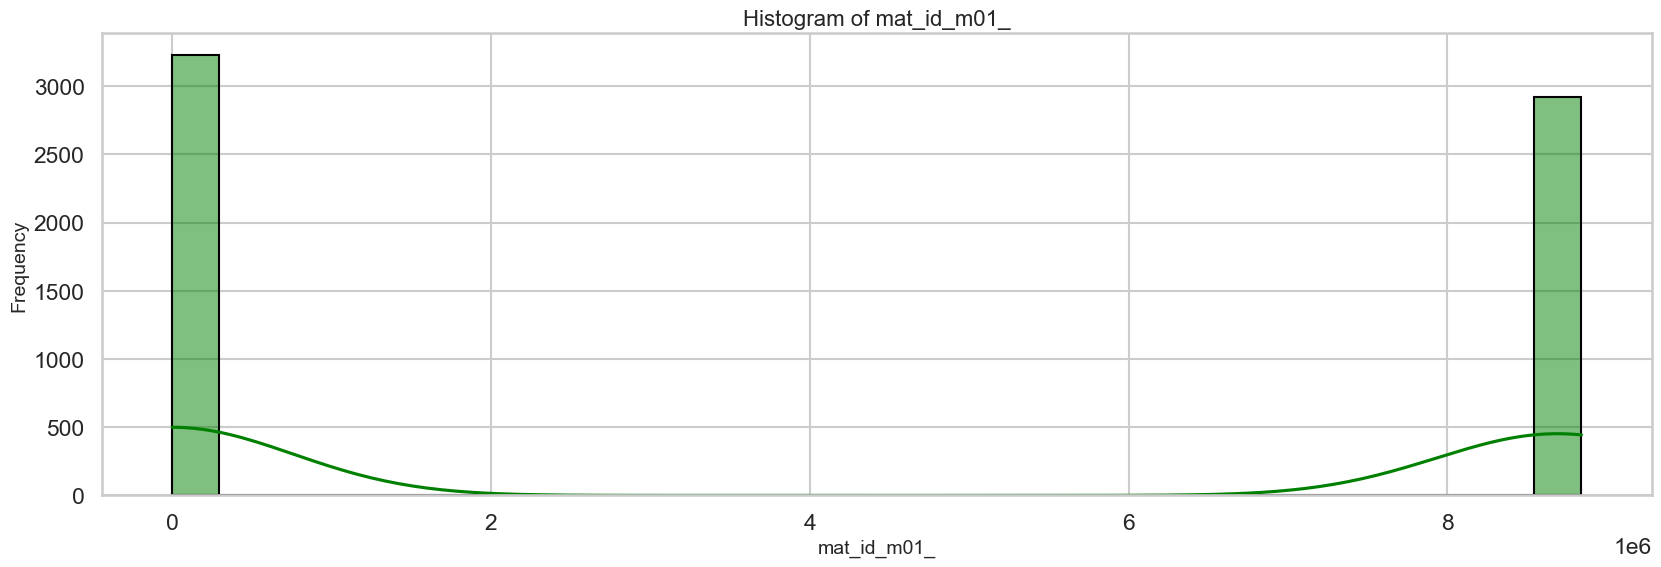

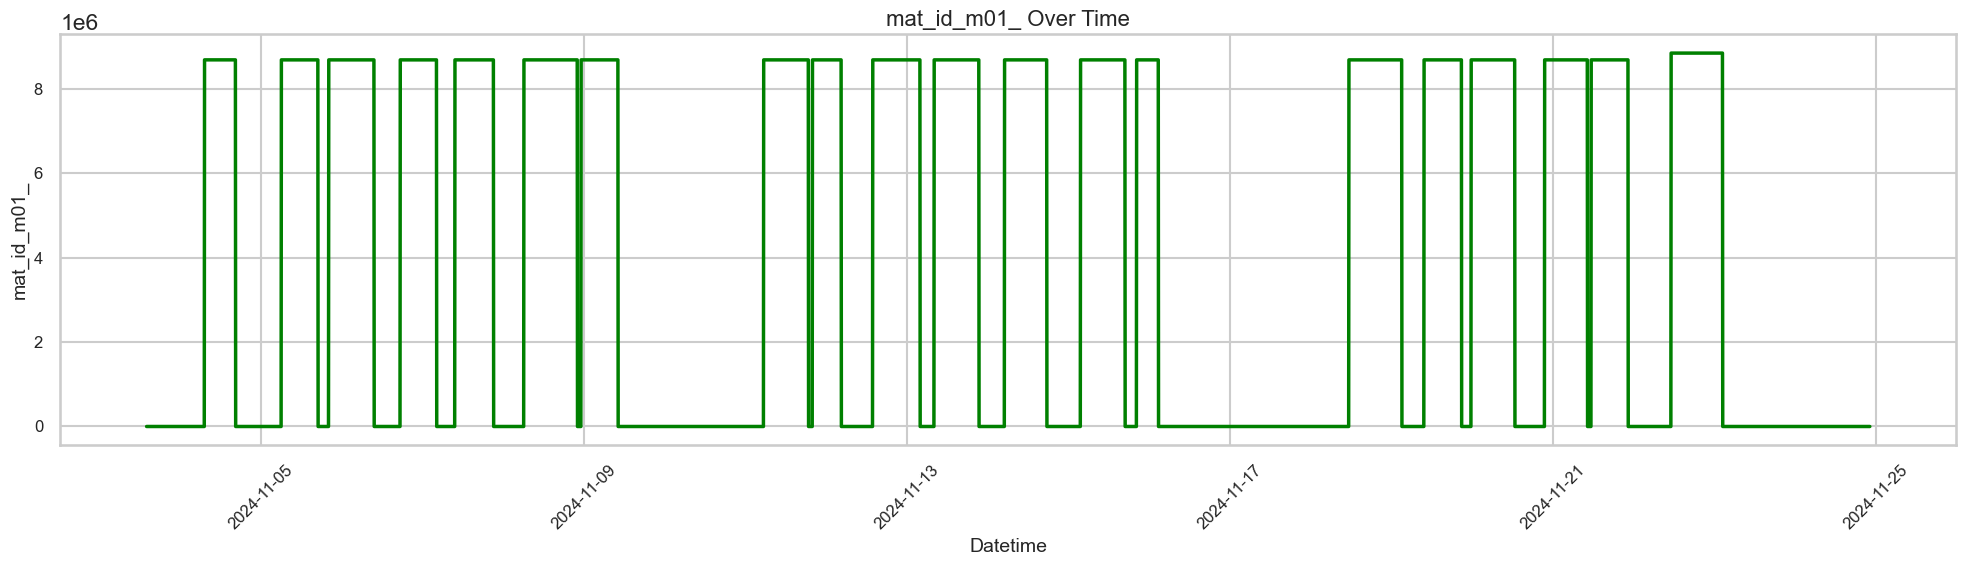

Variable: mat_id_m02_
count    6.147000e+03
mean     3.605681e+06
std      4.278448e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681590e+06
max      8.681697e+06
Name: mat_id_m02_, dtype: float64
Unique values: 6
------------------------------------------------------------


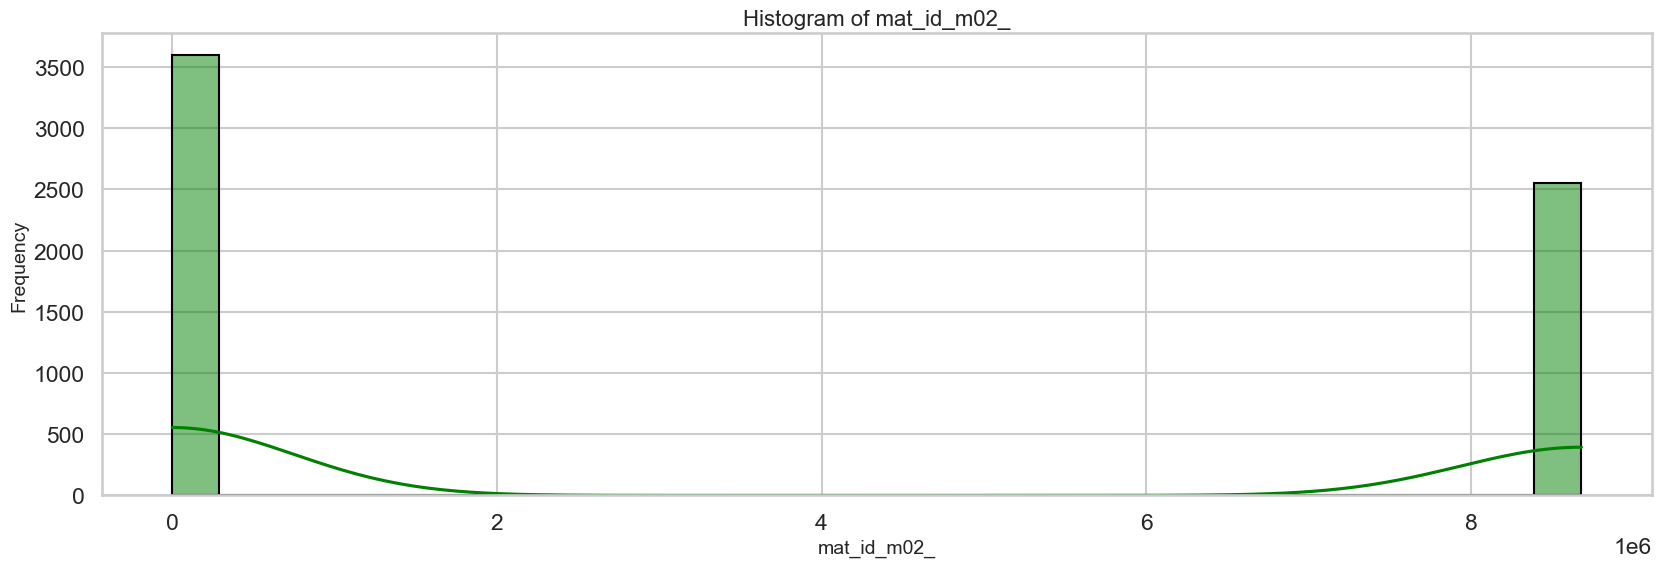

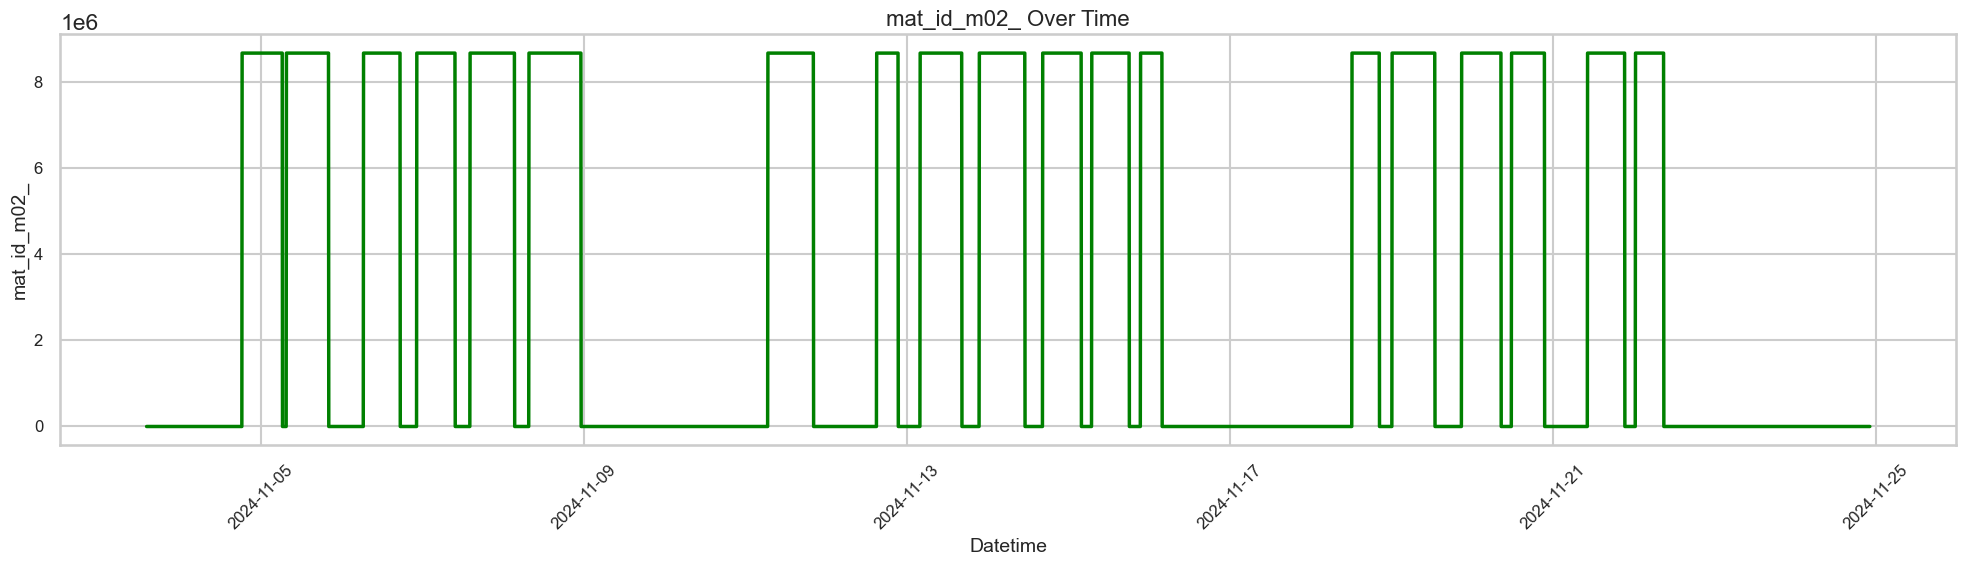

Variable: mat_id_m03_
count    6.147000e+03
mean     3.187631e+06
std      4.185164e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681588e+06
max      8.681697e+06
Name: mat_id_m03_, dtype: float64
Unique values: 5
------------------------------------------------------------


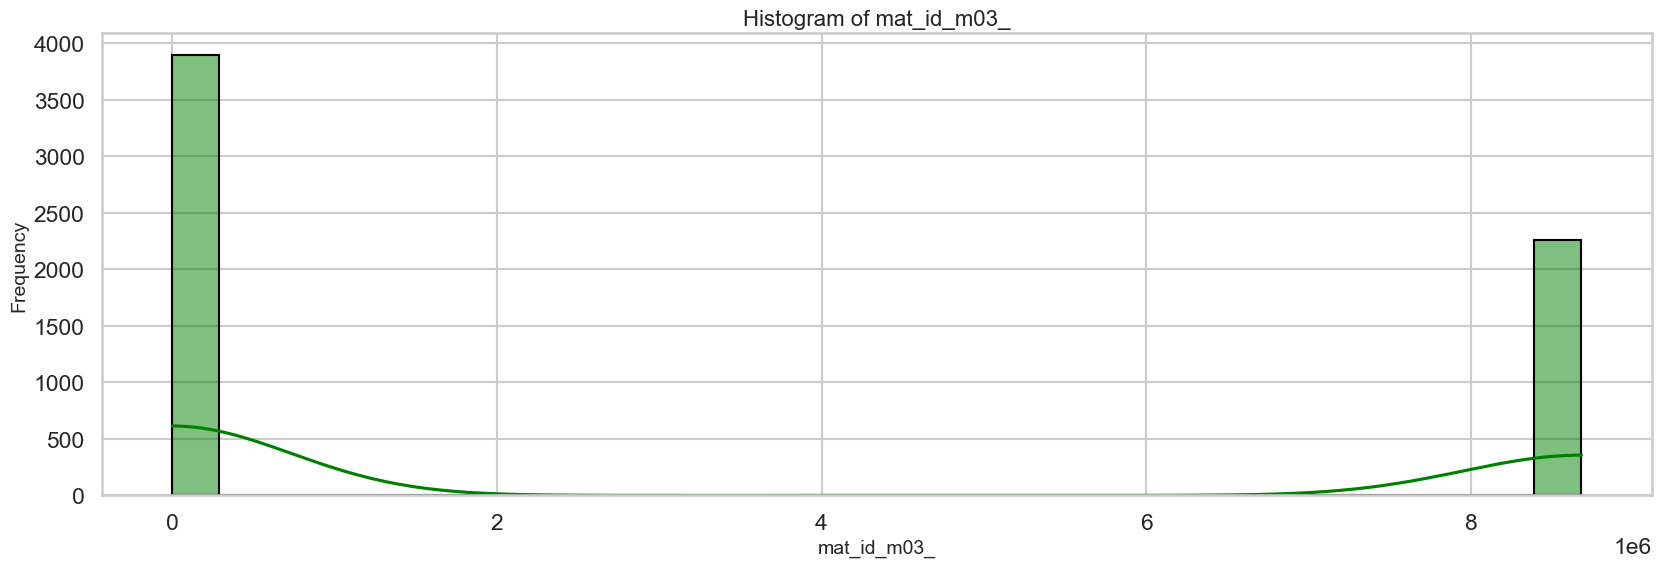

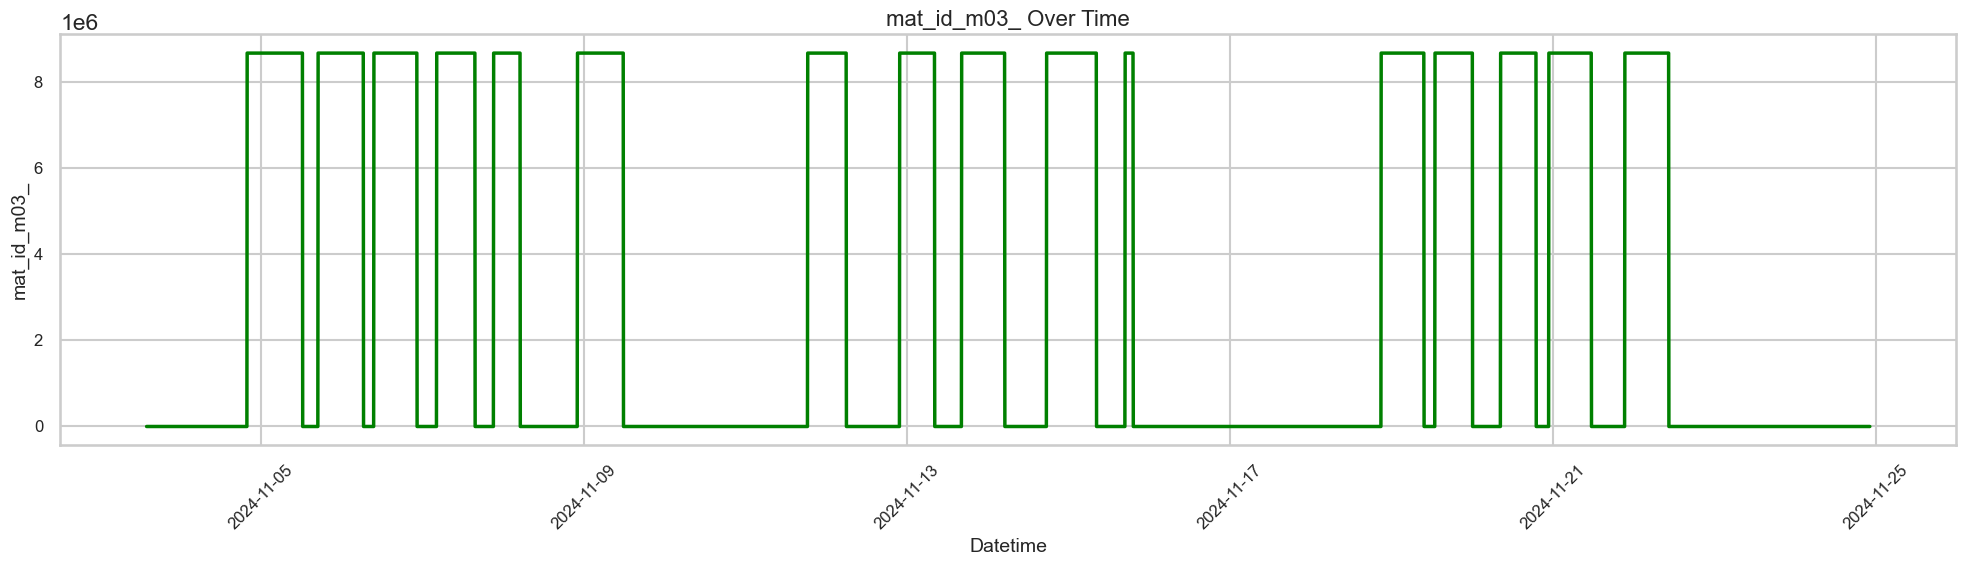

Variable: massenstrom_l01_
count     6147.000000
mean      1355.215551
std       4061.460635
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      20178.274642
Name: massenstrom_l01_, dtype: float64
Unique values: 829
------------------------------------------------------------


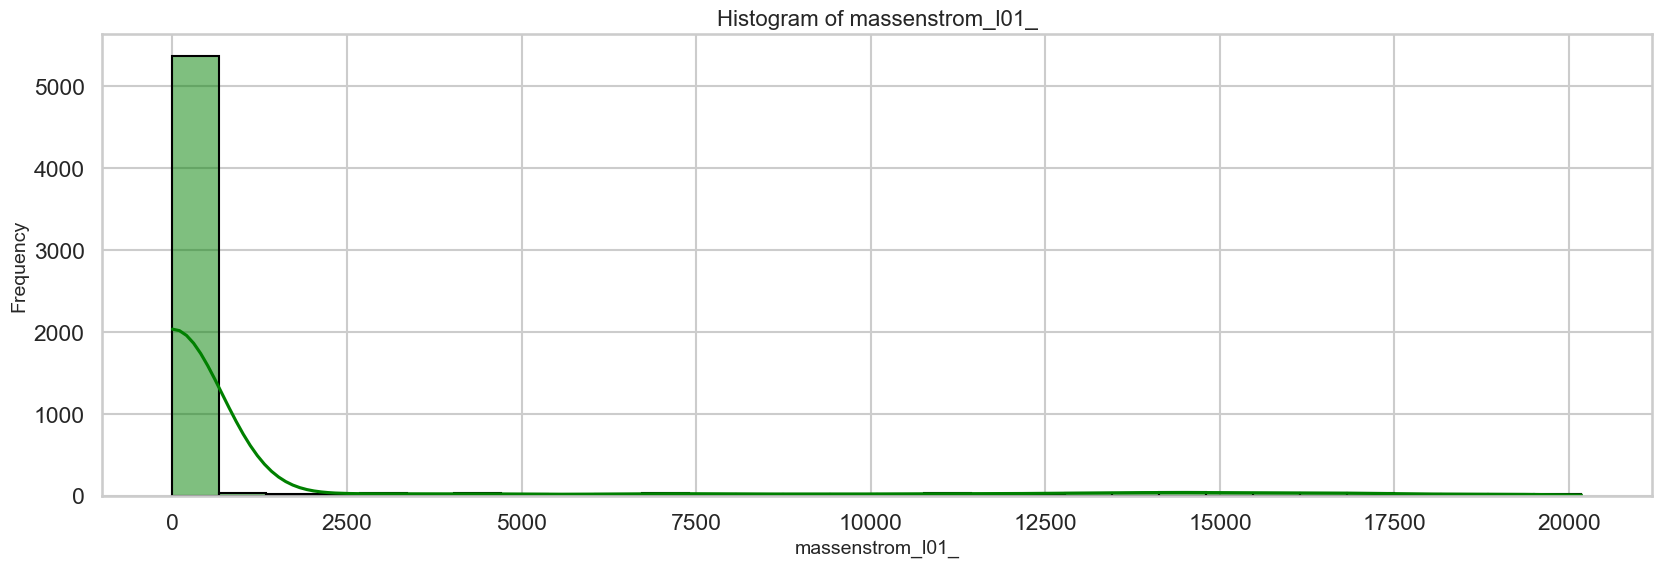

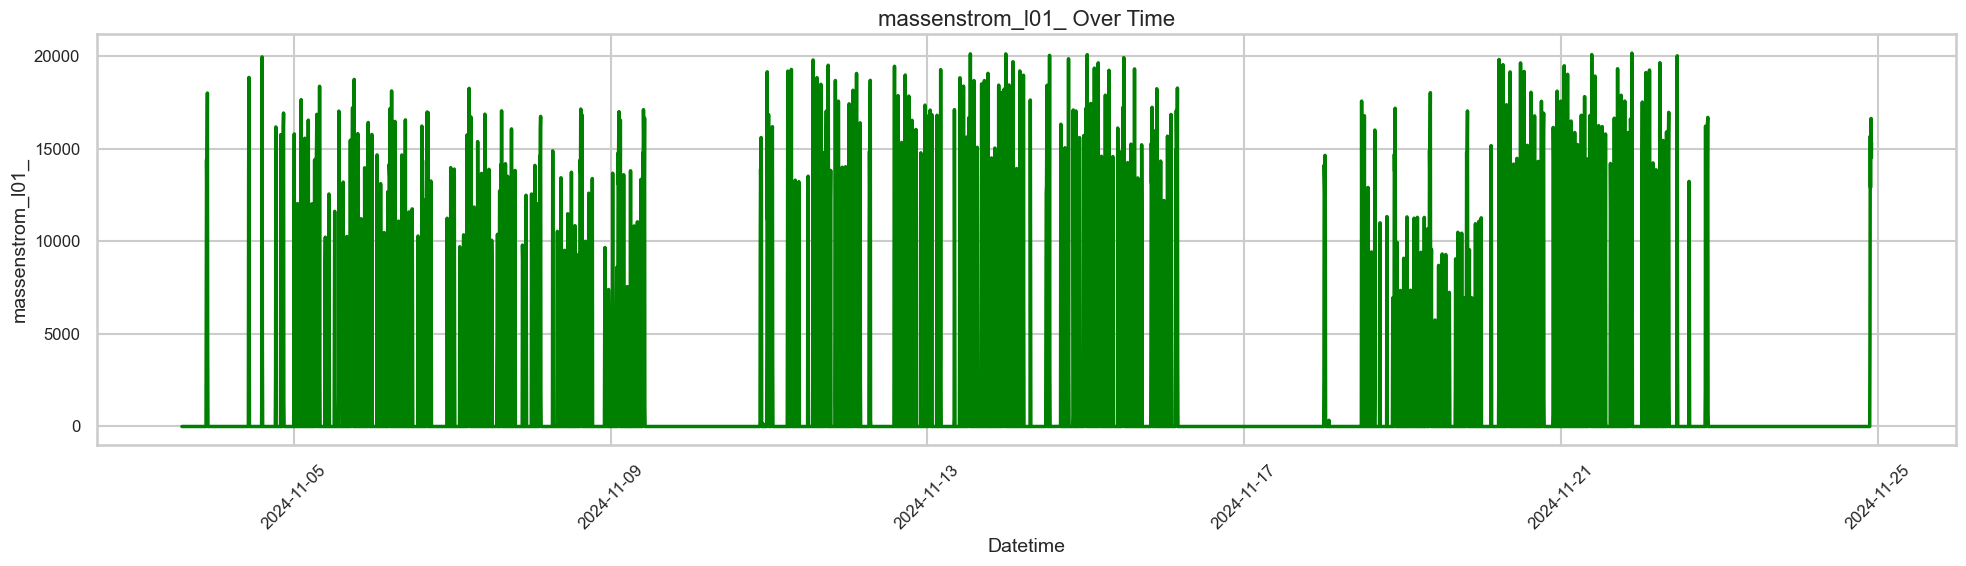

Variable: massenstrom_l02_
count     6147.000000
mean       978.875972
std       3441.588422
min       -668.368631
25%          0.000000
50%          0.000000
75%          0.000000
max      20844.150561
Name: massenstrom_l02_, dtype: float64
Unique values: 733
------------------------------------------------------------


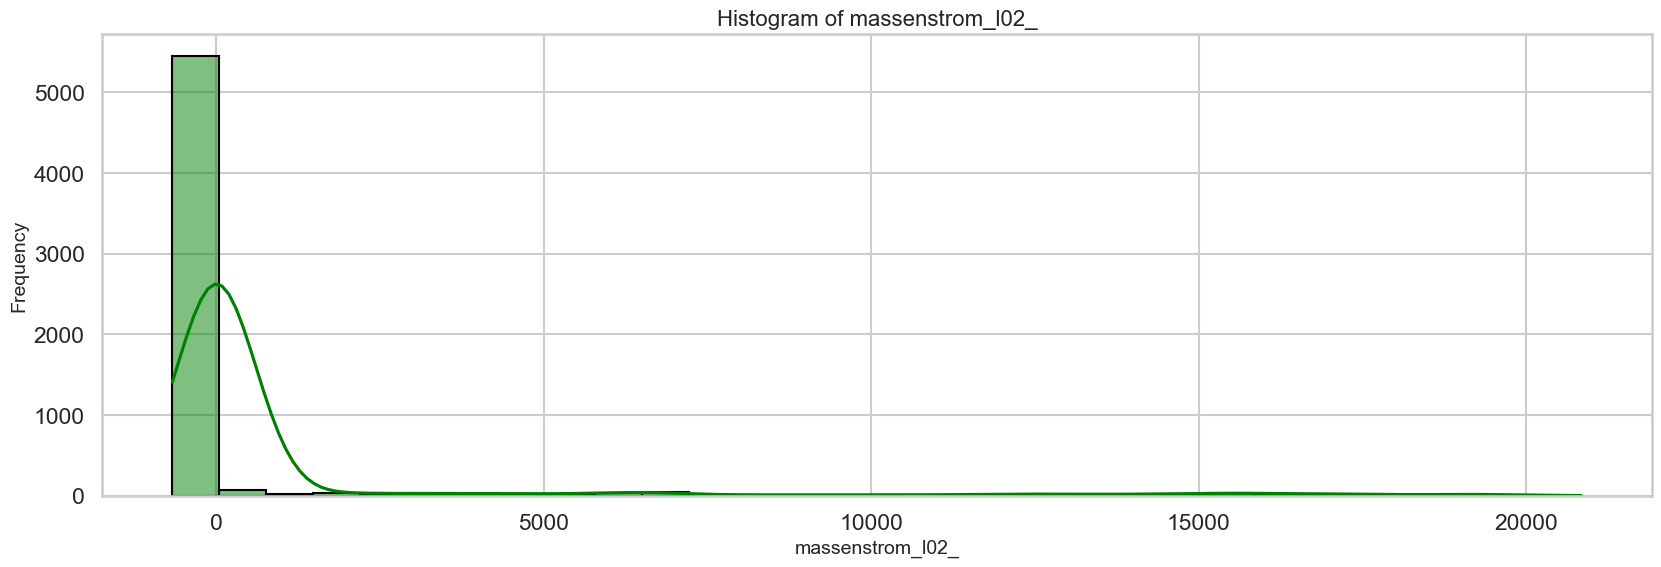

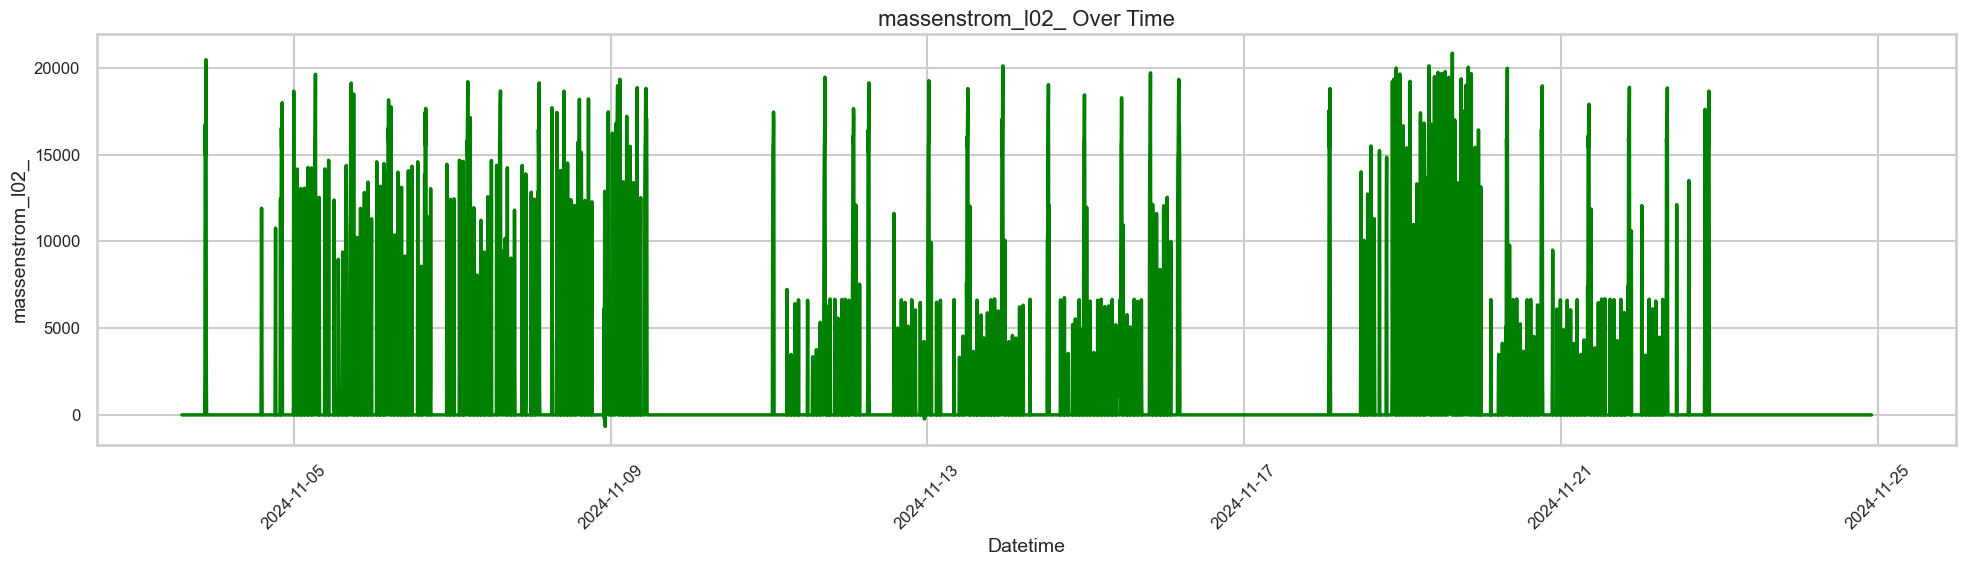

Variable: hw_l01_
count    6147.000000
mean       46.701197
std        10.812808
min        30.770309
25%        36.669786
50%        48.487684
75%        53.763654
max        77.814670
Name: hw_l01_, dtype: float64
Unique values: 6143
------------------------------------------------------------


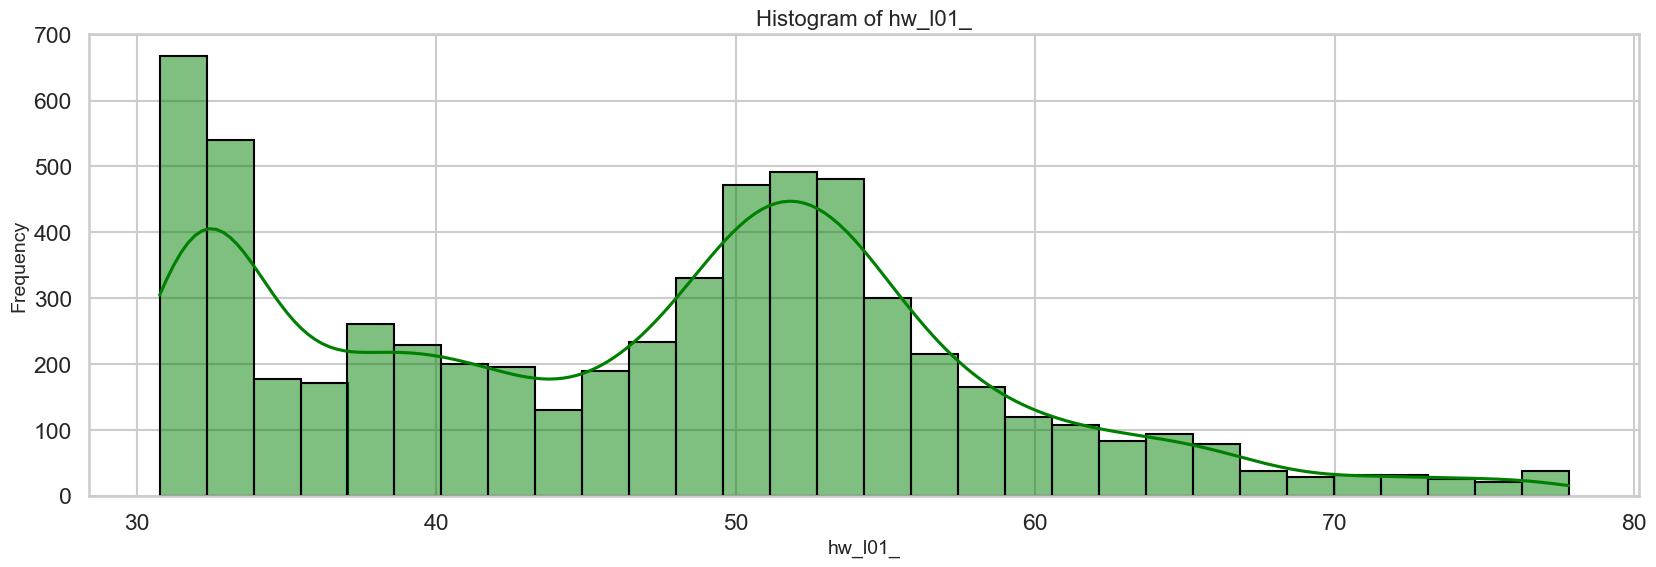

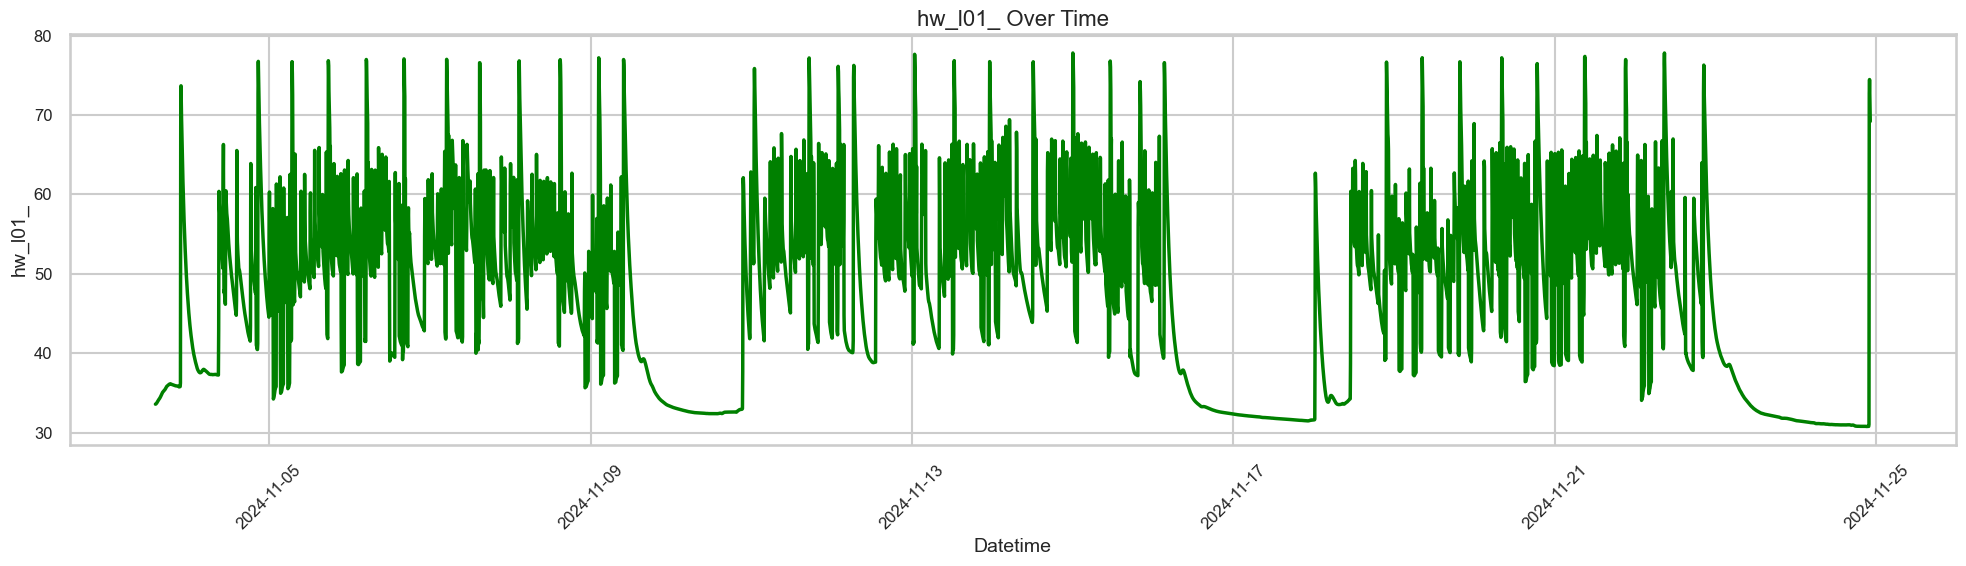

Variable: hw_l02_
count    6147.000000
mean       54.517348
std        17.317086
min        28.058540
25%        35.174108
50%        58.120208
75%        69.684200
max        89.812011
Name: hw_l02_, dtype: float64
Unique values: 6142
------------------------------------------------------------


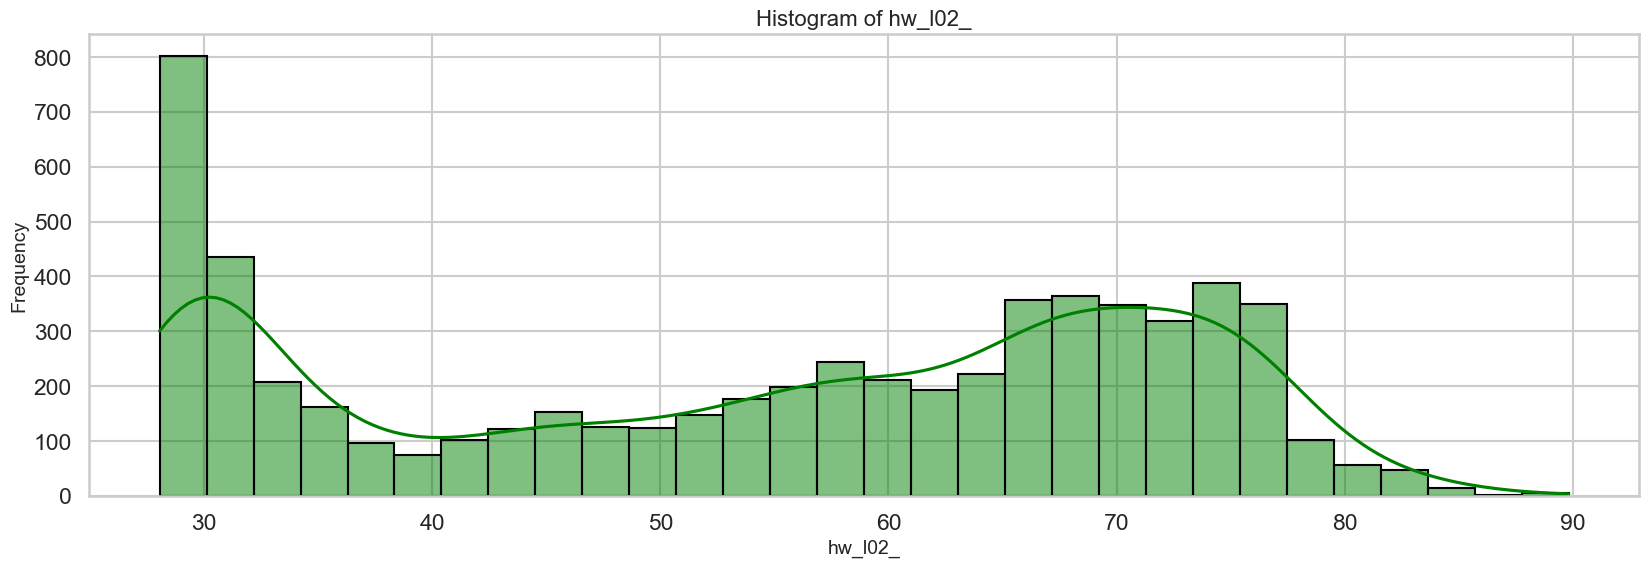

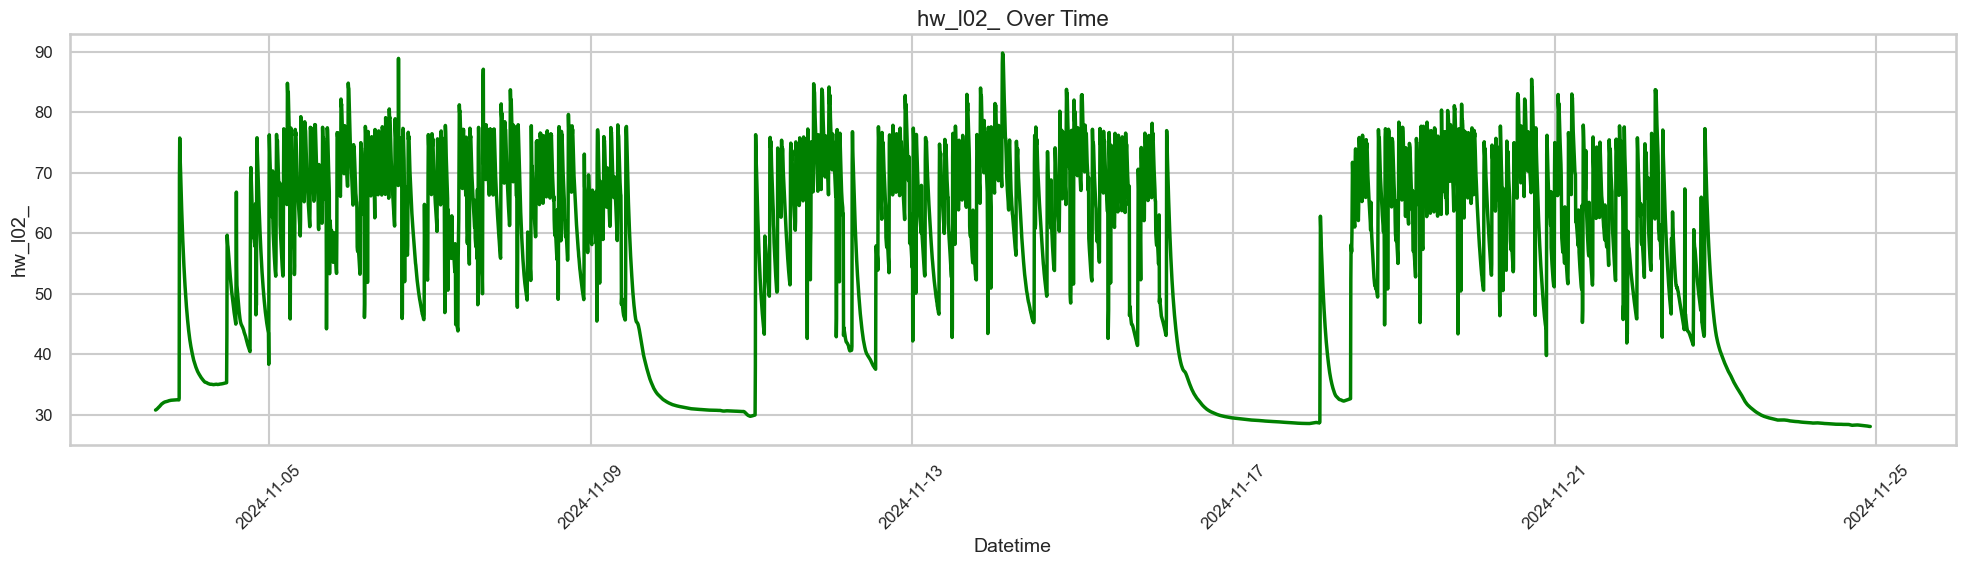

In [16]:
create_hide_button()

pd.set_option('display.max_rows', 10)
# Display the resampled DataFrame
display(df_resampled_5_min)
visualize_data(df_resampled_5_min, datetime_col="datetime", library="seaborn")

- [Index](#Index)

 # Visualize all variables per hour

In [17]:
create_hide_button()
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Display the resampled DataFrame
display(df_resampled_1H)
visualize_data(df_resampled_1H, datetime_col="datetime", library="plotly")

datetime  schritt_l01_  menge_l01_  menge_l02_  \
0   2024-11-03 14:31:38.500           0.0         0.0         0.0   
1   2024-11-03 15:29:58.500           0.0         0.0         0.0   
2   2024-11-03 16:29:58.500           0.0         0.0         0.0   
3   2024-11-03 17:29:58.500           0.0         0.0         0.0   
4   2024-11-03 18:29:58.500           0.0         0.0         0.0   
..                      ...           ...         ...         ...   
508 2024-11-24 18:29:58.500           0.0         0.0         0.0   
509 2024-11-24 19:29:58.500           0.0         0.0         0.0   
510 2024-11-24 20:29:58.500           0.0         0.0         0.0   
511 2024-11-24 21:29:58.500           0.0         0.0         0.0   
512 2024-11-24 22:05:18.500           0.0         0.0         0.0   

     schritt_l02_  temp_l01_  temp_l02_  mat_id_m01_  mat_id_m02_  \
0             0.0  31.265510  30.102778            0            0   
1             0.0  31.401458  30.520577            0            0   
2             0.0  31.587886  30.837756            0            0   
3             0.0  31.830874  30.985454            0            0   
4             0.0  32.250834  31.110531            0            0   
..            ...        ...        ...          ...          ...   
508           0.0  28.874097  26.958535            0            0   
509           0.0  28.820032  26.930602            0            0   
510           0.0  28.795422  26.904666            0            0   
511           0.0  38.519536  26.870358            0            0   
512           0.0  44.782596  26.847161            0            0   

     mat_id_m03_  massenstrom_l01_  massenstrom_l02_    hw_l01_    hw_l02_  
0              0          0.000000               0.0  33.805155  30.976443  
1              0          0.000000               0.0  34.466892  31.528750  
2              0          0.000000               0.0  35.209901  32.005532  
3              0          0.000000               0.0  35.806259  32.213240  
4              0          0.000000               0.0  36.103116  32.370327  
..           ...               ...               ...        ...        ...  
508            0          0.000000               0.0  30.798845  28.301286  
509            0          0.000000               0.0  30.792101  28.253046  
510            0          0.000000               0.0  30.787429  28.188296  
511            0       4148.644487               0.0  37.939378  28.111851  
512            0      15576.577255               0.0  71.410157  28.063795  

[513 rows x 14 columns]

Variable: schritt_l01_
count    513.000000
mean       5.306043
std       12.809828
min        0.000000
25%        0.000000
50%        4.000000
75%        4.000000
max      105.000000
Name: schritt_l01_, dtype: float64
Unique values: 6
------------------------------------------------------------


Variable: menge_l01_
count    513.000000
mean      55.007618
std       65.696445
min        0.000000
25%        0.000000
50%       19.194030
75%      112.225194
max      319.062782
Name: menge_l01_, dtype: float64
Unique values: 268
------------------------------------------------------------


Variable: menge_l02_
count    513.000000
mean      30.249428
std       53.789870
min        0.000000
25%        0.000000
50%        8.614221
75%       50.128766
max      578.885608
Name: menge_l02_, dtype: float64
Unique values: 263
------------------------------------------------------------


Variable: schritt_l02_
count    513.000000
mean       4.247563
std        9.215896
min        0.000000
25%        0.000000
50%        4.000000
75%        4.000000
max      105.000000
Name: schritt_l02_, dtype: float64
Unique values: 6
------------------------------------------------------------


Variable: temp_l01_
count    513.000000
mean      45.036510
std       13.066974
min       20.908731
25%       29.915018
50%       48.326423
75%       57.385284
max       67.489036
Name: temp_l01_, dtype: float64
Unique values: 513
------------------------------------------------------------


Variable: temp_l02_
count    513.000000
mean      51.004875
std       18.972730
min       21.494713
25%       28.966464
50%       54.884342
75%       70.658773
max       82.572639
Name: temp_l02_, dtype: float64
Unique values: 513
------------------------------------------------------------


Variable: mat_id_m01_
count    5.130000e+02
mean     4.100113e+06
std      4.343148e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681590e+06
max      8.842022e+06
Name: mat_id_m01_, dtype: float64
Unique values: 12
------------------------------------------------------------


Variable: mat_id_m02_
count    5.130000e+02
mean     3.621564e+06
std      4.284977e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681590e+06
max      8.681697e+06
Name: mat_id_m02_, dtype: float64
Unique values: 6
------------------------------------------------------------


Variable: mat_id_m03_
count    5.130000e+02
mean     3.215407e+06
std      4.196470e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.681588e+06
max      8.681697e+06
Name: mat_id_m03_, dtype: float64
Unique values: 5
------------------------------------------------------------


Variable: massenstrom_l01_
count      513.000000
mean      1376.037935
std       1955.074397
min          0.000000
25%          0.000000
50%        941.640994
75%       2164.566899
max      15576.577255
Name: massenstrom_l01_, dtype: float64
Unique values: 285
------------------------------------------------------------


Variable: massenstrom_l02_
count      513.000000
mean       977.444867
std       1724.133874
min          0.000000
25%          0.000000
50%        550.579192
75%       1221.643330
max      10735.411569
Name: massenstrom_l02_, dtype: float64
Unique values: 276
------------------------------------------------------------


Variable: hw_l01_
count    513.000000
mean      46.737656
std        9.584606
min       30.787429
25%       37.750621
50%       49.461783
75%       54.145463
max       71.410157
Name: hw_l01_, dtype: float64
Unique values: 513
------------------------------------------------------------


Variable: hw_l02_
count    513.000000
mean      54.478695
std       16.653423
min       28.063795
25%       35.192728
50%       59.722418
75%       69.286205
max       82.903729
Name: hw_l02_, dtype: float64
Unique values: 513
------------------------------------------------------------


- [Index](#Index)